ARIMA notebook for CURVE FITTING

In [10]:
import numpy
import pandas as pd
import pmdarima as pm
print(f"NumPy version: {numpy.__version__}")
print(f"pmdarima version: {pm.__version__}")
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import numpy as np




NumPy version: 1.26.4
pmdarima version: 2.0.4


Dataload and Prep

In [11]:
# Load the data
df = pd.read_csv(r"C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Maps\MapBiomas\Landuse\S.Lourenco\MPB_SAO_LOURENCO.csv")
df = df.drop(columns=['.geo'])
output_path = r'C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Generated Layers'

# Pivot it with class names instead of IDs
classes = df[['class', 'class_name']].drop_duplicates().set_index('class')['class_name'].to_dict()
pivot_df = df.pivot(index='year', columns='class', values='area_km2').fillna(0)
pivot_df.columns = [classes[col] for col in pivot_df.columns]  # Rename to class names here
pivot_df.index = pd.to_datetime(pivot_df.index, format='%Y')

# Quick peek
print("Pivot Data Preview:\n", pivot_df.head())
print("Columns (class names):", pivot_df.columns.tolist())
total_area_per_year = pivot_df.sum(axis=1)
print("Total area per year:\n", total_area_per_year.head())
avg_total = total_area_per_year.mean()
print(f"Average total area: {avg_total:.2f} km²")

# Save pivot
pivot_df.to_csv('landuse_pivot.csv')

# Proportions for ensemble prep
proportion_df = pivot_df.div(total_area_per_year, axis=0)
print("Proportion Data Preview:\n", proportion_df.head())

Pivot Data Preview:
             Forest Formation  Savanna Formation  Forest Plantation  \
year                                                                 
1985-01-01       5983.741658        9167.957930           0.000000   
1986-01-01       5776.421779        8749.158732           0.000000   
1987-01-01       5638.364670        8553.257526           0.000000   
1988-01-01       5506.065291        8337.276342           0.030076   
1989-01-01       5490.038008        8068.979956           0.305462   

               Wetland  Grassland (Pastizal, Formación Herbácea)      Pasture  \
year                                                                            
1985-01-01  979.518420                                840.094316  2751.512287   
1986-01-01  633.610333                               1182.418475  3215.764437   
1987-01-01  723.240430                               1017.184968  3785.184288   
1988-01-01  822.841031                                923.960917  4388.526671   
19

In [12]:
print(output_path)

C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Generated Layers


In [13]:
your_dataframe = df

print(df.head().to_string())

print(your_dataframe.info()) # Shows column names, non-null counts, dtypes, index type
print(your_dataframe.shape)  # Shows (number_of_rows, number_of_columns)

  system:index     area_km2  year  class                 band                                class_name
0        0_0_0  5983.741658  1985      3  classification_1985                          Forest Formation
1        0_0_1  9167.957930  1985      4  classification_1985                         Savanna Formation
2        0_0_2   979.518420  1985     11  classification_1985                                   Wetland
3        0_0_3   840.094316  1985     12  classification_1985  Grassland (Pastizal, Formación Herbácea)
4        0_0_4  2751.512287  1985     15  classification_1985                                   Pasture
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  564 non-null    object 
 1   area_km2      564 non-null    float64
 2   year          564 non-null    int64  
 3   class         564 non-null    int64  
 4   band     

In [14]:
# BLOCK 3: ARIMA MODEL (Modified for Full Data Retraining)



# Assuming pivot_df is available from Block 1
if 'pivot_df' not in globals():
    raise NameError("pivot_df not defined. Run Block 1 first.")

# Define forecast horizon and dates
n_forecast = 10  # 2024-2033
test_end_dt = pd.to_datetime('2023') # Consistent with Block 4 test_end
forecast_start_dt = test_end_dt + pd.DateOffset(years=1)
forecast_end_dt = forecast_start_dt + pd.DateOffset(years=n_forecast - 1)

# Store results - Ensure index covers full range
# Use index similar to Block 4's ensemble_preds for consistency
hist_start_dt = pivot_df.index.min()
full_index_arima = pd.date_range(start=hist_start_dt, end=forecast_end_dt, freq='YS')
forecast_df = pd.DataFrame(index=full_index_arima, columns=pivot_df.columns, dtype=float)
# Fill historical known values
common_hist_index = pivot_df.index.intersection(forecast_df.index)
forecast_df.loc[common_hist_index] = pivot_df.loc[common_hist_index]

# --- Evaluation Phase (using original train/test split) ---
print("===== ARIMA Evaluation Phase (Train up to 2015) =====")
train_eval_df = pivot_df.loc[:'2015']
test_eval_df = pivot_df.loc['2016':'2023'] # Test period for evaluation
mse_dict_eval = {}
test_predictions_eval = pd.DataFrame(index=test_eval_df.index, columns=pivot_df.columns) # Store test preds

for class_name in pivot_df.columns:
    print(f"\nProcessing Class {class_name} for Evaluation:")
    series_train_eval = train_eval_df[class_name]

    try:
        # Auto ARIMA on training data only (up to 2015)
        model_eval = pm.auto_arima(series_train_eval, start_p=1, start_q=1, max_p=5, max_q=5,
                                   d=None, seasonal=False, stepwise=True,
                                   suppress_warnings=True, error_action='warn', trace=False) # trace=False reduces verbosity
        print(f"  Eval Model Order: {model_eval.order}")

        # Predict test period (2016-2023) for evaluation
        test_pred = model_eval.predict(n_periods=len(test_eval_df))
        test_predictions_eval[class_name] = test_pred
        mse = mean_squared_error(test_eval_df[class_name], test_pred)
        mse_dict_eval[class_name] = mse
        print(f"  MSE on Test Period (2016-2023): {mse:.2f}")

    except Exception as e:
        print(f"  Error fitting/evaluating ARIMA for Class {class_name}: {e}")
        mse_dict_eval[class_name] = np.nan
        test_predictions_eval[class_name] = np.nan

print("\nARIMA Evaluation Summary (Model trained to 2015, tested on 2016-2023):")
print(pd.Series(mse_dict_eval, name='MSE_ARIMA_Eval'))
avg_mse_eval = np.nanmean(list(mse_dict_eval.values()))
print(f"Average Eval MSE across classes: {avg_mse_eval:.2f}")


# --- Final Forecast Phase (Retrain on Full Data up to 2023) ---
print("\n===== ARIMA Final Forecast Phase (Retrain up to 2023) =====")
# No need to store test predictions here, only future forecast

for class_name in pivot_df.columns:
    print(f"\nRefitting and Forecasting Class {class_name}:")
    # Use ALL historical data up to the end of the test period
    series_full_history = pivot_df.loc[:test_end_dt, class_name]

    try:
        # Auto ARIMA on FULL historical data (up to 2023)
        model_final = pm.auto_arima(series_full_history, start_p=1, start_q=1, max_p=5, max_q=5,
                                    d=None, seasonal=False, stepwise=True,
                                    suppress_warnings=True, error_action='ignore', trace=False) # Ignore errors in final fit if possible
        print(f"  Final Model Order: {model_final.order}")

        # Forecast future (2024-2033) using the fully retrained model
        future_forecast = model_final.predict(n_periods=n_forecast)

        # Store the final forecast values
        forecast_df.loc[forecast_start_dt:, class_name] = future_forecast

    except Exception as e:
        print(f"  Error refitting/forecasting FINAL ARIMA for Class {class_name}: {e}")
        # Leave future forecast as NaN or fill with a fallback (e.g., last value)
        # forecast_df.loc[forecast_start_dt:, class_name] = series_full_history.iloc[-1] # Example fallback


# --- Post-Processing (Normalization - Optional but recommended) ---
print("\nNormalizing FINAL ARIMA forecasts to average total area...")
if 'avg_total' not in globals():
     print("Warning: avg_total not found. Calculating from historical pivot_df.")
     avg_total = pivot_df.loc[:test_end_dt].sum(axis=1).mean() # Use historical average
     print(f"Calculated avg_total: {avg_total:.2f}")

for year_idx in forecast_df.loc[forecast_start_dt:].index:
    year_values = forecast_df.loc[year_idx]
    # Clip negative forecasts to zero before summing/normalizing
    year_values_clipped = year_values.clip(lower=0)
    year_sum = year_values_clipped.sum()
    if year_sum > 0:
        forecast_df.loc[year_idx] = (year_values_clipped / year_sum) * avg_total
    else:
        # Handle case where all forecasts are zero or negative
        forecast_df.loc[year_idx] = 0

# Final fillna just in case
forecast_df = forecast_df.fillna(0)

# Save final forecast
arima_final_output_path = r'C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Maps\MapBiomas\Landuse\S.Lourenco\arima_forecast_final_retrained.csv' # New name
forecast_df.to_csv(arima_final_output_path)
print(f"FINAL Retrained ARIMA forecast saved to {arima_final_output_path}")
print("\n===== Block 3 Execution Finished =====")

In [16]:
# BLOCK 4: ENSEMBLE MODELS (RF, XGB, LSTM) - Retrain on Full History + Target Lags

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
# Current time: Tuesday, April 8, 2025 at 12:11 PM -03 (Brazil Time)

# Ensure plots show inline
%matplotlib inline

# --- Configuration ---
output_folder_block4 = r'C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Generated Layers\Block4_Outputs'
os.makedirs(output_folder_block4, exist_ok=True)

# --- Function Definitions (create_lagged_features, create_sequences - Keep as before) ---
def create_lagged_features(df, lags=5):
    lagged_df = pd.DataFrame(index=df.index); df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1): lagged_df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return lagged_df.dropna()

def create_sequences(data, timesteps):
    X, y = [], []; data_values = data.values if isinstance(data, (pd.DataFrame, pd.Series)) else data
    if data_values.ndim == 1: data_values = data_values.reshape(-1, 1)
    if len(data_values) <= timesteps: return np.array(X), np.array(y)
    n_features = data_values.shape[1]
    for i in range(len(data_values) - timesteps):
        X.append(data_values[i:(i + timesteps), :]); y.append(data_values[i + timesteps, :])
    return np.array(X), np.array(y)

# --- Parameters ---
lags = 2; timesteps = 2
train_end = '2015'; val_start = '2016'; val_end = '2020'
test_start = '2021'; test_end = '2023'
n_forecast = 10

# --- Data Splitting & Prep ---
if 'proportion_df' not in globals(): raise NameError("proportion_df not defined.")
train_df = proportion_df.loc[:train_end]
val_df = proportion_df.loc[val_start:val_end]
test_df = proportion_df.loc[test_start:test_end]
# Create data for retraining on full history
full_history_df = proportion_df.loc[:test_end] # Data up to 2023

# Feature Engineering (Train/Val/Test for Eval + Full History for Final Model)
lagged_train = create_lagged_features(train_df, lags)
lagged_val = create_lagged_features(val_df, lags)
lagged_test = create_lagged_features(test_df, lags)
lagged_full_history = create_lagged_features(full_history_df, lags) # For retraining
if lagged_val.empty or lagged_test.empty or lagged_full_history.empty: raise ValueError("Lagged set empty.")

X_train_lstm, y_train_lstm = create_sequences(train_df, timesteps)
X_val_lstm, y_val_lstm = create_sequences(val_df, timesteps)
X_test_lstm, y_test_lstm = create_sequences(test_df, timesteps)
X_full_lstm, y_full_lstm = create_sequences(full_history_df, timesteps) # For retraining

# --- Storage ---
final_models_storage = {} # Stores the FINAL models retrained on full data
mse_dict_ensemble_eval = {} # Stores MSE from evaluation on test set
all_class_names = proportion_df.columns.tolist()

# Result DataFrame Setup
forecast_start_dt = pd.to_datetime(test_end) + pd.DateOffset(years=1)
forecast_end_dt = forecast_start_dt + pd.DateOffset(years=n_forecast - 1)
hist_start_dt = proportion_df.index.min()
full_index_ens = pd.date_range(start=hist_start_dt, end=forecast_end_dt, freq='YS')
ensemble_preds = pd.DataFrame(index=full_index_ens, columns=all_class_names, dtype=float)
common_index_hist = pivot_df.index.intersection(ensemble_preds.index)
ensemble_preds.loc[common_index_hist] = pivot_df.loc[common_index_hist]

# Class colors
class_colors = { 'Forest Formation': 'green', 'Savanna Formation': 'gold', 'Forest Plantation': 'brown', 'Wetland': 'darkcyan', 'Grassland (Pastizal, Formación Herbácea)': 'lightgreen', 'Pasture': 'beige', 'Sugar Cane': 'lightseagreen', 'Mosaic of Agriculture and Pasture': '#c3af68', 'Urban Infrastructure': 'red', 'Other Non Vegetated Area': '#7f5d5d', 'Rocky outcrop': 'gray', 'River, Lake and Ocean': 'dodgerblue', 'Soy Beans': 'magenta', 'Mosaic of Crops': 'orchid', 'Cotton': 'lightpink' }
for col in all_class_names: class_colors.setdefault(col, 'grey')


# ================================================================
# ===== STEP 1: Eval Models, Calc Weights, Retrain Final Models ==
# ================================================================
print("===== Starting Model Eval / Retrain Phase =====")
for class_name in all_class_names:
    print(f"\n--- Processing: {class_name} ---")
    # Target variables
    y_train = train_df[class_name]; y_val = val_df[class_name]
    y_test = test_df[class_name]; y_full = full_history_df[class_name]

    # Features (USING ALL LAGS)
    features_to_use = lagged_train.columns.tolist() # Use all lags based on train set columns
    if not features_to_use: print(f"Warning: No features. Skipping {class_name}."); continue

    # Prep data for EVALUATION (train up to 2015, val 2016-2020, test 2021-2023)
    X_train_eval = lagged_train[features_to_use]
    y_train_eval = y_train.loc[X_train_eval.index]
    X_val_eval = lagged_val.reindex(columns=features_to_use, fill_value=0)
    y_val_eval = y_val.loc[X_val_eval.index]
    X_test_eval = lagged_test.reindex(columns=features_to_use, fill_value=0)
    y_test_eval = y_test.loc[X_test_eval.index]

    # Prep data for FINAL RETRAINING (up to 2023)
    X_retrain = lagged_full_history.reindex(columns=features_to_use, fill_value=0) # Ensure consistent features
    y_retrain = y_full.loc[X_retrain.index]

    # --- Train Models for EVALUATION (on train_df only) ---
    # RF Eval
    rf_eval = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf_eval.fit(X_train_eval, y_train_eval)
    rf_val_pred = rf_eval.predict(X_val_eval.reindex(columns=rf_eval.feature_names_in_, fill_value=0))
    # XGB Eval
    xgb_eval = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
    xgb_eval.fit(X_train_eval, y_train_eval)
    xgb_val_pred = xgb_eval.predict(X_val_eval.reindex(columns=xgb_eval.feature_names_in_, fill_value=0))
    # LSTM Eval
    class_idx = all_class_names.index(class_name)
    y_train_lstm_eval = y_train_lstm[:, class_idx]; y_val_lstm_eval = y_val_lstm[:, class_idx]
    # Define Sequential model correctly
    lstm_eval = Sequential([
        Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), name="lstm_eval_input"), # Input Layer
        LSTM(32, name="lstm_eval_layer"),                                  # LSTM Layer instance
        Dense(1, name="lstm_eval_output")                                   # Dense Layer instance
    ])
    lstm_eval.compile(optimizer='adam', loss='mse')
    lstm_trained_eval = False; lstm_val_pred = np.array([])
    if X_train_lstm.shape[0] > 0 and X_val_lstm.shape[0] > 0:
        lstm_eval.fit(X_train_lstm, y_train_lstm_eval, epochs=20, batch_size=32, validation_data=(X_val_lstm, y_val_lstm_eval), verbose=0)
        lstm_val_pred = lstm_eval.predict(X_val_lstm, verbose=0).flatten()
        lstm_trained_eval = True

    # --- Calculate Ensemble Weights (based on Eval models' performance on Val set) ---
    rf_mse=np.inf; xgb_mse=np.inf; lstm_mse=np.inf
    if len(y_val_eval) == len(rf_val_pred): rf_mse = mean_squared_error(y_val_eval, rf_val_pred)
    if len(y_val_eval) == len(xgb_val_pred): xgb_mse = mean_squared_error(y_val_eval, xgb_val_pred)
    lstm_target_val_idx = val_df.index[timesteps:]
    if len(lstm_target_val_idx) == len(lstm_val_pred) and lstm_trained_eval: lstm_mse = mean_squared_error(val_df[class_name].loc[lstm_target_val_idx], lstm_val_pred)
    epsilon=1e-9; inv_rf=1/(rf_mse+epsilon); inv_xgb=1/(xgb_mse+epsilon); inv_lstm=1/(lstm_mse+epsilon)
    total_inv = inv_rf + inv_xgb + inv_lstm
    if total_inv > 0: rf_w=inv_rf/total_inv; xgb_w=inv_xgb/total_inv; lstm_w=inv_lstm/total_inv
    else: rf_w=xgb_w=lstm_w=1/3
    print(f"  Eval Weights: RF={rf_w:.2f}, XGB={xgb_w:.2f}, LSTM={lstm_w:.2f}")

    # --- Evaluate Ensemble on Test Set (using Eval models) ---
    rf_test_pred = rf_eval.predict(X_test_eval.reindex(columns=rf_eval.feature_names_in_, fill_value=0))
    xgb_test_pred = xgb_eval.predict(X_test_eval.reindex(columns=xgb_eval.feature_names_in_, fill_value=0))
    lstm_test_pred = np.full(len(X_test_lstm), np.nan)
    if lstm_trained_eval and X_test_lstm.shape[0] > 0: lstm_test_pred = lstm_eval.predict(X_test_lstm, verbose=0).flatten()
    # Align preds
    test_pred_idx = X_test_eval.index
    rf_s = pd.Series(rf_test_pred, index=test_pred_idx); xgb_s = pd.Series(xgb_test_pred, index=test_pred_idx)
    lstm_s = pd.Series(np.nan, index=test_pred_idx)
    lstm_test_idx = test_df.index[timesteps:]
    if len(lstm_test_idx)==len(lstm_test_pred): lstm_s = pd.Series(lstm_test_pred, index=lstm_test_idx).reindex(test_pred_idx)
    # Ensemble calc
    ens_test_pred = (rf_w*rf_s.fillna(0) + xgb_w*xgb_s.fillna(0) + lstm_w*lstm_s.fillna(0))
    # Eval MSE
    y_test_aligned = y_test_eval # Target already aligned
    if len(y_test_aligned)==len(ens_test_pred): mse_dict_ensemble_eval[class_name] = mean_squared_error(y_test_aligned, ens_test_pred)
    else: mse_dict_ensemble_eval[class_name] = np.nan
    print(f"  Eval Test MSE: {mse_dict_ensemble_eval.get(class_name, float('nan')):.6f}")
    # Store eval test predictions (proportions) in main df
    ensemble_preds.loc[test_pred_idx, class_name] = ens_test_pred.values

    # --- RETRAIN FINAL Models on Full History ---
    print(f"  Retraining models on full history (up to {test_end})...")
    # Retrain RF
    rf_final = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf_final.fit(X_retrain, y_retrain)
    # Retrain XGB
    xgb_final = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
    xgb_final.fit(X_retrain, y_retrain)
    # Retrain LSTM
    y_full_lstm_class = y_full_lstm[:, class_idx]
    # Define Sequential model correctly
    lstm_final = Sequential([
        Input(shape=(X_full_lstm.shape[1], X_full_lstm.shape[2]), name="lstm_final_input"), # Input Layer
        LSTM(32, name="lstm_final_layer"),                                    # LSTM Layer instance
        Dense(1, name="lstm_final_output")                                     # Dense Layer instance
    ])
    lstm_final.compile(optimizer='adam', loss='mse')
    lstm_trained_final = False
    if X_full_lstm.shape[0] > 0:
        lstm_final.fit(X_full_lstm, y_full_lstm_class, epochs=30, batch_size=32, verbose=0) # Maybe more epochs for final model
        lstm_trained_final = True

    # Store FINAL models and weights
    final_models_storage[class_name] = {
        'rf': rf_final, 'xgb': xgb_final, 'lstm': lstm_final,
        'weights': (rf_w, xgb_w, lstm_w), # Use weights calculated from eval
        'features_rf': rf_final.feature_names_in_, # Features expected by final model
        'features_xgb': xgb_final.feature_names_in_,
        'lstm_trained': lstm_trained_final
    }

print("===== Model Eval / Retrain Phase Finished =====")


# ================================================================
# ===== STEP 2: Recursive Forecasting (Using FINAL Models) =======
# ================================================================
print(f"\n===== Starting Recursive Forecast Phase ({n_forecast} steps) =====")
# Prep initial inputs (use lagged_test and X_test_lstm as before)
initial_lagged_features_df = lagged_test.iloc[-1:].copy()
initial_lstm_sequence_np = X_test_lstm[-1:].copy() if X_test_lstm.shape[0] > 0 else np.zeros((1, timesteps, X_train_lstm.shape[2])) # Use train shape for feature count consistency
current_lagged_features_df = initial_lagged_features_df
current_lstm_sequence_np = initial_lstm_sequence_np

# Main Loop
for i in range(n_forecast):
    forecast_year_dt = forecast_start_dt + pd.DateOffset(years=i)
    print(f"  Predicting for year: {forecast_year_dt.year} (Step {i+1}/{n_forecast})")
    current_step_predictions = pd.Series(index=all_class_names, dtype=float)

    for class_name in all_class_names:
        if class_name not in final_models_storage: continue # Skip if no model stored

        models_info = final_models_storage[class_name]
        # Use FINAL models
        rf_model, xgb_model, lstm_model = models_info['rf'], models_info['xgb'], models_info['lstm']
        rf_weight, xgb_weight, lstm_weight = models_info['weights']
        rf_features = models_info['features_rf'] # Use feature names from FINAL model
        xgb_features = models_info['features_xgb']
        lstm_trained = models_info['lstm_trained']

        rf_pred_step=0; xgb_pred_step=0; lstm_pred_step=0
        if not current_lagged_features_df.empty:
             X_pred_rf = current_lagged_features_df.reindex(columns=rf_features, fill_value=0)
             X_pred_xgb = current_lagged_features_df.reindex(columns=xgb_features, fill_value=0)
             if X_pred_rf.shape[1] == len(rf_features) and rf_model: rf_pred_step = rf_model.predict(X_pred_rf)[0]
             if X_pred_xgb.shape[1] == len(xgb_features) and xgb_model: xgb_pred_step = xgb_model.predict(X_pred_xgb)[0]

        if current_lstm_sequence_np.size > 0 and lstm_trained and lstm_model:
             lstm_pred_step = lstm_model.predict(current_lstm_sequence_np, verbose=0).flatten()[0]

        pred_step = rf_weight*rf_pred_step + xgb_weight*xgb_pred_step + lstm_weight*lstm_pred_step
        pred_step = np.clip(pred_step, 0, 1)
        current_step_predictions[class_name] = pred_step

    # Store & Update Features (Logic remains the same)
    if forecast_year_dt in ensemble_preds.index: ensemble_preds.loc[forecast_year_dt] = current_step_predictions.values
    else: print(f"Warning: Year {forecast_year_dt} not in index.")
    # Feature update
    next_lagged_row = pd.Series(index=current_lagged_features_df.columns, dtype=float)
    for class_n in all_class_names:
        lag1_col = f"{class_n}_lag1"; next_lagged_row[lag1_col] = current_step_predictions[class_n]
        for lag_idx in range(2, lags + 1):
            prev_lag_col = f"{class_n}_lag{lag_idx-1}"; cur_lag_col = f"{class_n}_lag{lag_idx}"
            if cur_lag_col in next_lagged_row.index and prev_lag_col in current_lagged_features_df.columns:
                next_lagged_row[cur_lag_col] = current_lagged_features_df[prev_lag_col].iloc[0]
            elif cur_lag_col in next_lagged_row.index: next_lagged_row[cur_lag_col] = 0
    current_lagged_features_df = pd.DataFrame([next_lagged_row])
    if current_lstm_sequence_np.size > 0:
        new_vec = current_step_predictions.values.reshape(1, 1, -1); rolled = np.roll(current_lstm_sequence_np, -1, axis=1)
        rolled[:, -1, :] = new_vec; current_lstm_sequence_np = rolled

print("===== Recursive Forecast Phase Finished =====")


# ================================================================
# ===== STEP 3: Normalize & Finalize (Remains the same) =========
# ================================================================
print("\nNormalizing ensemble forecasts...")
# (Normalization logic is identical to previous version)
if 'avg_total' not in globals(): avg_total = pivot_df.loc[:test_end].sum(axis=1).mean()
prediction_period_index = ensemble_preds.loc[test_start:].index # Eval Test + Forecast
for year_idx in prediction_period_index:
    year_props = ensemble_preds.loc[year_idx].copy(); year_sum = year_props.fillna(0).sum()
    if year_sum > 0: ensemble_preds.loc[year_idx] = (year_props/year_sum)*avg_total
    else: ensemble_preds.loc[year_idx] = 0
ensemble_preds = ensemble_preds.fillna(0)

print("\nEnsemble MSE Summary (on test set proportions using EVAL models):")
ensemble_mse_series = pd.Series(mse_dict_ensemble_eval, name='Ensemble_MSE_Eval').dropna().sort_values() # Use Eval MSE
print(ensemble_mse_series); print(f"Average Eval MSE: {ensemble_mse_series.mean():.6f}")

# Save final results
ensemble_preds_abs_path = os.path.join(output_folder_block4, 'ensemble_forecast_absolute_final_retrained.csv') # New filename
ensemble_preds.to_csv(ensemble_preds_abs_path)
print(f"Final ensemble forecast saved to {ensemble_preds_abs_path}")

# Plotting (Make sure forecast_df from modified Block 3 is available if plotting comparison)
# Use arima_final_df if running separately, or forecast_df if Block 3 output variable is named that
arima_plot_df = forecast_df if 'forecast_df' in globals() else None # Check if ARIMA results are in memory

if arima_plot_df is not None:
    print("\nGenerating comparison plots...")
    for class_name in pivot_df.columns:
        fig, ax = plt.subplots(figsize=(12, 6))
        # Original Data
        ax.plot(pivot_df.index, pivot_df[class_name], 'o', color=class_colors.get(class_name, 'grey'), markersize=5, label='Original Data')
        # ARIMA (Retrained)
        ax.plot(arima_plot_df.index, arima_plot_df[class_name].ffill().fillna(0), color='cyan', linestyle='--', linewidth=1.5, label='ARIMA (Retrained)')
        # Ensemble (Retrained)
        ax.plot(ensemble_preds.index, ensemble_preds[class_name], color=class_colors.get(class_name, 'grey'), linestyle='-', linewidth=2.5, label='Ensemble (Retrained)')
        # Formatting
        ax.axvline(x=pd.to_datetime(test_end), color='red', linestyle=':', label='Forecast Start')
        ax.set_title(f'{class_name} - FINAL Forecast Comparison (Retrained Models)')
        ax.set_xlabel('Year'); ax.set_ylabel('Area (km²)')
        ax.legend(); ax.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(rotation=45); plt.tight_layout()
        plot_path = os.path.join(output_folder_block4, f'Final_Compare_Retrained_{class_name.replace(" ", "_").replace("/", "_")}.png') # New filename
        plt.savefig(plot_path, dpi=150); plt.close(fig)
    print("Comparison plots saved.")
else: print("\nSkipping comparison plots as retrained ARIMA forecast_df is not available.")

print("\n===== Block 4 Execution Finished =====")

===== Starting Model Eval / Retrain Phase =====

--- Processing: Forest Formation ---
  Eval Weights: RF=0.79, XGB=0.21, LSTM=0.00
  Eval Test MSE: 0.000005
  Retraining models on full history (up to 2023)...

--- Processing: Savanna Formation ---
  Eval Weights: RF=0.12, XGB=0.88, LSTM=0.00
  Eval Test MSE: 0.000152
  Retraining models on full history (up to 2023)...

--- Processing: Forest Plantation ---
  Eval Weights: RF=0.11, XGB=0.77, LSTM=0.12
  Eval Test MSE: 0.000004
  Retraining models on full history (up to 2023)...

--- Processing: Wetland ---
  Eval Weights: RF=0.48, XGB=0.30, LSTM=0.23
  Eval Test MSE: 0.000002
  Retraining models on full history (up to 2023)...

--- Processing: Grassland (Pastizal, Formación Herbácea) ---
  Eval Weights: RF=0.36, XGB=0.23, LSTM=0.41
  Eval Test MSE: 0.000002
  Retraining models on full history (up to 2023)...

--- Processing: Pasture ---
  Eval Weights: RF=0.34, XGB=0.66, LSTM=0.00
  Eval Test MSE: 0.000181
  Retraining models on full hi

In [18]:
# BLOCK 5: APPLY STABILITY FILTER (Run AFTER Block 3)


print("\n===== Applying Stability Filter (Based on Last 5 Years) =====")

# --- Configuration ---
STABILITY_YEARS = 5 # Look at the last 5 years of history
STD_DEV_THRESHOLD = 0.5 # Example threshold for std dev (ADJUST AS NEEDED)
RANGE_THRESHOLD = 1.0   # Example threshold for range (max-min) (ADJUST AS NEEDED)

# --- Load the Forecast to be Filtered ---
# Assuming the final retrained ARIMA forecast is the one to filter
# Use the variable name from Block 3 (forecast_df) or load from CSV
forecast_to_filter_df = None
if 'forecast_df' in globals():
    forecast_to_filter_df = forecast_df.copy()
    print("Using forecast_df from Block 3 in memory.")
else:
    # Load from file if not in memory
    arima_final_output_path = r'C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Maps\MapBiomas\Landuse\S.Lourenco\arima_forecast_final_retrained.csv' # Path from Block 3
    if os.path.exists(arima_final_output_path):
        print(f"Loading retrained ARIMA forecast from: {arima_final_output_path}")
        forecast_to_filter_df = pd.read_csv(arima_final_output_path, index_col=0, parse_dates=True)
    else:
        raise FileNotFoundError(f"Cannot find forecast file to filter: {arima_final_output_path}. Run Block 3 first.")

# Ensure pivot_df (with historical absolute values) is available
if 'pivot_df' not in globals():
    raise NameError("pivot_df historical data not found. Run Block 1.")

# --- Identify Near-Constant Classes based on Last 5 Years ---
classes_to_filter = []
history_end_dt = pd.to_datetime(test_end) # Should be 2023-01-01 or similar
history_start_dt_filter = history_end_dt - pd.DateOffset(years=STABILITY_YEARS - 1)

print(f"Checking stability between {history_start_dt_filter.year} and {history_end_dt.year}...")

# Use pivot_df which contains the historical absolute values
relevant_history = pivot_df.loc[:history_end_dt] # History up to 2023

for class_name in relevant_history.columns:
    # Select the series for the last N years
    series_last_n_years = relevant_history.loc[history_start_dt_filter:history_end_dt, class_name].dropna()

    if len(series_last_n_years) >= 2: # Need at least 2 points
        series_std = series_last_n_years.std()
        series_range = series_last_n_years.max() - series_last_n_years.min()

        # Check if BOTH conditions are met
        # Use pd.notna checks for safety, although dropna should handle it
        if pd.notna(series_std) and pd.notna(series_range) and \
           series_std < STD_DEV_THRESHOLD and series_range < RANGE_THRESHOLD:
            print(f"  * Identified '{class_name}' as stable recently (StdDev: {series_std:.3f}, Range: {series_range:.3f}). Will apply filter.")
            classes_to_filter.append(class_name)
        # Optional: Print stats for classes that didn't meet the threshold for debugging
        # else:
        #    print(f"  - '{class_name}' not flagged (StdDev: {series_std:.3f}, Range: {series_range:.3f})")

    # Handle cases with less than 2 data points in the window if necessary
    # else:
    #    print(f"  - '{class_name}' has less than 2 data points in the last {STABILITY_YEARS} years.")


# --- Apply Filter: Override Forecast with Last Known Value ---
print(f"\nApplying filter to {len(classes_to_filter)} classes...")
last_historical_values = relevant_history.iloc[-1] # Values from 2023

# Define forecast period start date (consistent with Blocks 3 & 4)
forecast_start_dt = pd.to_datetime(test_end) + pd.DateOffset(years=1) # Start year 2024

for class_name in classes_to_filter:
    if class_name in forecast_to_filter_df.columns:
        last_value = last_historical_values.get(class_name, 0) # Get 2023 value, default 0
        print(f"  Overriding forecast for '{class_name}' with last value: {last_value:.2f}")
        # Apply only to the forecast period (2024 onwards)
        forecast_period_mask = forecast_to_filter_df.index >= forecast_start_dt
        forecast_to_filter_df.loc[forecast_period_mask, class_name] = last_value

print("Stability filter application complete.")

# --- Save Filtered Results ---
# Define output folder consistently
output_folder_filter = output_folder_block4 # Use same output folder as Block 4 or define new one
filtered_output_path = os.path.join(output_folder_filter, 'final_forecast_filtered.csv') # Final name
forecast_to_filter_df.to_csv(filtered_output_path)
print(f"Filtered forecast saved to {filtered_output_path}")


# --- Optional: Generate Plots for Filtered Results ---
print("\nGenerating plots for the filtered forecast...")
# Make sure class_colors is defined (copy from Block 4 if needed)
if 'class_colors' not in globals():
    class_colors = { 'Forest Formation': 'green', 'Savanna Formation': 'gold', 'Forest Plantation': 'brown', 'Wetland': 'darkcyan', 'Grassland (Pastizal, Formación Herbácea)': 'lightgreen', 'Pasture': 'beige', 'Sugar Cane': 'lightseagreen', 'Mosaic of Agriculture and Pasture': '#c3af68', 'Urban Infrastructure': 'red', 'Other Non Vegetated Area': '#7f5d5d', 'Rocky outcrop': 'gray', 'River, Lake and Ocean': 'dodgerblue', 'Soy Beans': 'magenta', 'Mosaic of Crops': 'orchid', 'Cotton': 'lightpink' }
    for col in forecast_to_filter_df.columns: class_colors.setdefault(col, 'grey')

for class_name in forecast_to_filter_df.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    # Original Data
    if 'pivot_df' in globals():
         ax.plot(pivot_df.index, pivot_df[class_name], 'o', color=class_colors.get(class_name, 'grey'), markersize=5, label='Original Data')
    # Filtered Forecast
    ax.plot(forecast_to_filter_df.index, forecast_to_filter_df[class_name], color=class_colors.get(class_name, 'grey'), linestyle='-', linewidth=2.5, label='Final Forecast (Filtered)')
    # Indicate if filter was applied
    if class_name in classes_to_filter:
         ax.text(0.05, 0.95, 'Stability Filter Applied', transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', fc='orange', alpha=0.7))

    ax.axvline(x=pd.to_datetime(test_end), color='red', linestyle=':', label='Forecast Start')
    ax.set_title(f'{class_name} - Final Land Use Area Forecast (Filtered)')
    ax.set_xlabel('Year'); ax.set_ylabel('Area (km²)')
    ax.legend(); ax.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45); plt.tight_layout()
    plot_path = os.path.join(output_folder_filter, f'Final_Filtered_{class_name.replace(" ", "_").replace("/", "_")}.png')
    plt.savefig(plot_path, dpi=150); plt.close(fig)
print("Filtered forecast plots saved.")

print("\n===== Block 5 (Filter) Execution Finished =====")


===== Applying Stability Filter (Based on Last 5 Years) =====
Using forecast_df from Block 3 in memory.
Checking stability between 2019 and 2023...
  * Identified 'Sugar Cane' as stable recently (StdDev: 0.011, Range: 0.029). Will apply filter.
  * Identified 'Rocky outcrop' as stable recently (StdDev: 0.073, Range: 0.189). Will apply filter.

Applying filter to 2 classes...
  Overriding forecast for 'Sugar Cane' with last value: 0.04
  Overriding forecast for 'Rocky outcrop' with last value: 289.30
Stability filter application complete.
Filtered forecast saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Generated Layers\Block4_Outputs\final_forecast_filtered.csv

Generating plots for the filtered forecast...
Filtered forecast plots saved.

===== Block 5 (Filter) Execution Finished =====


Curve Fitting and Evaluation

In [71]:
# %% BLOCK_6__MLP_[SOLS]_4_5 (Modified to Store Eval Predictions)

# --- Imports (Ensure necessary ones are loaded) ---
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd # Make sure pandas is imported
import numpy as np  # Make sure numpy is imported
import os
import matplotlib.pyplot as plt # Keep for plotting at the end

print("\n===== Starting Block 6 [SOLS]_4_5: MLP Forecast (L2, A0.1, NoScale, Deep Arch, TrendFeat) =====")

# --- Configuration ---
# (Configuration section remains the same)
mlp_hidden_layers = (64, 32, 16)
mlp_activation = 'relu'
mlp_solver = 'adam'
mlp_max_iter = 1000
mlp_eval_max_iter = 500 # Max iter for the EVAL model
mlp_early_stopping = True
mlp_random_state = 42
mlp_alpha = 0.1 # L2 regularization alpha

lags = 2
timesteps = lags # Often same as lags for MLP feature prep
time_feature_col = 'time_feature'

print(f"MLP Config: Lags={lags}, Alpha={mlp_alpha}, HiddenLayers={mlp_hidden_layers}, Scaled=False, TrendFeature=True")

# --- Output Folder ---
# (Output folder definition remains the same)
output_folder_mlp = r'C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Generated Layers\Block6_MLP_Outputs'
os.makedirs(output_folder_mlp, exist_ok=True)

# --- Stability Filter Config (Used later in the block) ---
# (Stability filter config remains the same)
STABILITY_YEARS = 5
STD_DEV_THRESHOLD = 0.5
RANGE_THRESHOLD = 1.0
print(f"Filter Config: StabilityYears={STABILITY_YEARS}, StdDevThresh={STD_DEV_THRESHOLD}, RangeThresh={RANGE_THRESHOLD}")


# --- Data Splitting & Prep ---
# (Data splitting and feature prep remains the same)
if 'proportion_df' not in globals() or 'pivot_df' not in globals(): raise NameError("proportion_df or pivot_df not defined.")
# Ensure train/val/test periods are defined (copy from Block 4 if needed)
if 'train_end' not in globals(): train_end = '2015'
if 'test_start' not in globals(): test_start = '2021'
if 'test_end' not in globals(): test_end = '2023'
if 'n_forecast' not in globals(): n_forecast = 10

test_end_dt = pd.to_datetime(test_end); forecast_start_dt = test_end_dt + pd.DateOffset(years=1)
forecast_end_dt = forecast_start_dt + pd.DateOffset(years=n_forecast - 1); hist_start_dt = proportion_df.index.min()

train_df_mlp = proportion_df.loc[:train_end]
test_df_mlp = proportion_df.loc[test_start:test_end] # Data for the test period
full_history_df_mlp = proportion_df.loc[:test_end] # Data up to end of test period

# Feature Engineering Functions (assuming they are defined or copy them here)
if 'create_lagged_features' not in globals():
    def create_lagged_features(df, lags=2):
        lagged_df = pd.DataFrame(index=df.index); df = df.copy()
        for col in df.columns:
            for lag in range(1, lags + 1): lagged_df[f'{col}_lag{lag}'] = df[col].shift(lag)
        return lagged_df.dropna()

if 'add_time_feature' not in globals():
     def add_time_feature(lagged_df, base_year):
         df = lagged_df.copy()
         df[time_feature_col] = df.index.year - base_year
         return df

base_year_for_time_feature = hist_start_dt.year

lagged_train_mlp_base = create_lagged_features(train_df_mlp, lags)
lagged_train_mlp = add_time_feature(lagged_train_mlp_base, base_year_for_time_feature)

lagged_test_mlp_base = create_lagged_features(test_df_mlp, lags) # Features for 2021-2023 targets
lagged_test_mlp = add_time_feature(lagged_test_mlp_base, base_year_for_time_feature)

lagged_full_history_mlp_base = create_lagged_features(full_history_df_mlp, lags)
lagged_full_history_mlp = add_time_feature(lagged_full_history_mlp_base, base_year_for_time_feature)

if lagged_test_mlp.empty or lagged_full_history_mlp.empty: raise ValueError(f"Lagged set empty (lags={lags}). Check date ranges and data availability.")


# --- Storage ---
final_mlp_models = {} # Stores final retrained models
mse_dict_mlp_eval = {} # Stores eval MSE (proportions)
all_class_names_mlp = proportion_df.columns.tolist()

# --- ADDED CODE: Initialize DataFrame for Eval Predictions ---
# This DataFrame will store the proportion predictions from the EVALUATION model on the test set (2021-2023)
mlp_eval_test_predictions_prop = pd.DataFrame(index=lagged_test_mlp.index, columns=all_class_names_mlp, dtype=float)
print(f"Initialized DataFrame for storing MLP evaluation test predictions (shape: {mlp_eval_test_predictions_prop.shape})")
# --- END ADDED CODE ---

# Result DataFrame Setup (for final forecast)
# (This part remains the same)
full_index_mlp = pd.date_range(start=hist_start_dt, end=forecast_end_dt, freq='YS')
mlp_preds = pd.DataFrame(index=full_index_mlp, columns=all_class_names_mlp, dtype=float)
hist_fill_end_dt = test_end_dt
common_index_hist_fill = pivot_df.index.intersection(mlp_preds.loc[:hist_fill_end_dt].index)
mlp_preds.loc[common_index_hist_fill] = pivot_df.loc[common_index_hist_fill]
print(f"Filled historical data in mlp_preds up to {hist_fill_end_dt.year}.")

# Class colors
# (Class colors definition remains the same)
if 'class_colors' not in globals(): class_colors = {c: 'grey' for c in all_class_names_mlp}


# ============================================================================================
# ===== STEP 1: Evaluate MLP & Retrain Final MLP =========
# ============================================================================================
print(f"\n===== Starting MLP Eval & Retrain Phase (Lags={lags}, Alpha={mlp_alpha}, Arch={mlp_hidden_layers}, TrendFeat, No Scaling) =====")
for class_name in all_class_names_mlp:
    print(f"\n--- Processing MLP for: {class_name} ---")
    # Target variables (proportions)
    y_train = train_df_mlp[class_name]
    y_test = test_df_mlp[class_name] # Target for 2021-2023 period
    y_full = full_history_df_mlp[class_name] # Target up to 2023

    features_to_use = lagged_train_mlp.columns.tolist()
    if not features_to_use: print(f"Warning: No features. Skipping {class_name}."); continue

    # Prep eval data (aligning features and targets)
    X_train_eval_raw = lagged_train_mlp[features_to_use]
    y_train_eval = y_train.loc[X_train_eval_raw.index] # Target for training eval model

    X_test_eval_raw = lagged_test_mlp.reindex(columns=features_to_use, fill_value=0) # Features for 2021-2023 period
    y_test_eval = y_test.loc[X_test_eval_raw.index] # Target for 2021-2023 period

    # --- Train MLP for EVALUATION ---
    print(f"  Evaluating with lags={lags}, alpha={mlp_alpha}, arch={mlp_hidden_layers}, trend feat (No Scaling)...")
    mlp_eval = MLPRegressor(hidden_layer_sizes=mlp_hidden_layers, activation=mlp_activation, solver=mlp_solver,
                            max_iter=mlp_eval_max_iter, random_state=mlp_random_state, alpha=mlp_alpha,
                            early_stopping=mlp_early_stopping, n_iter_no_change=10, verbose=False)
    try:
         mlp_eval.fit(X_train_eval_raw, y_train_eval)
         print(f"    Eval model trained (Loss: {mlp_eval.loss_:.6f}, Iterations: {mlp_eval.n_iter_})")

         # Evaluate on Test Set (predict proportions for 2021-2023)
         if not X_test_eval_raw.empty and len(X_test_eval_raw) == len(y_test_eval):
             features_eval_in = list(X_train_eval_raw.columns) # Use features from training
             mlp_test_pred = mlp_eval.predict(X_test_eval_raw.reindex(columns=features_eval_in, fill_value=0))
             mlp_test_mse = mean_squared_error(y_test_eval, mlp_test_pred)
             mse_dict_mlp_eval[class_name] = mlp_test_mse
             print(f"    Eval Test MSE (Proportions): {mlp_test_mse:.6f}")

             # --- ADDED CODE: Store Eval Prediction ---
             if len(mlp_test_pred) == len(mlp_eval_test_predictions_prop.index):
                 mlp_eval_test_predictions_prop.loc[X_test_eval_raw.index, class_name] = mlp_test_pred # Use correct index
             else:
                 print(f"    Warning: Length mismatch storing eval pred for {class_name}.")
                 mlp_eval_test_predictions_prop.loc[X_test_eval_raw.index, class_name] = np.nan # Store NaN if mismatch
             # --- END ADDED CODE ---

         else:
             print(f"    Warning: Could not evaluate MLP on test set for {class_name} (data shape mismatch or empty).")
             mse_dict_mlp_eval[class_name] = np.nan
             mlp_eval_test_predictions_prop.loc[X_test_eval_raw.index, class_name] = np.nan # Store NaN

    except Exception as e_fit_eval:
         print(f"    Error during MLP evaluation for {class_name}: {e_fit_eval}")
         mse_dict_mlp_eval[class_name] = np.nan
         if not X_test_eval_raw.empty:
             mlp_eval_test_predictions_prop.loc[X_test_eval_raw.index, class_name] = np.nan # Store NaN


    # --- RETRAIN FINAL Model (remains the same) ---
    print(f"  Retraining FINAL model with lags={lags}, alpha={mlp_alpha}, arch={mlp_hidden_layers}, trend feat (No Scaling)...")
    X_retrain_raw = lagged_full_history_mlp.reindex(columns=features_to_use, fill_value=0)
    y_retrain = y_full.loc[X_retrain_raw.index]

    mlp_final = MLPRegressor(hidden_layer_sizes=mlp_hidden_layers, activation=mlp_activation, solver=mlp_solver,
                             max_iter=mlp_max_iter, random_state=mlp_random_state, alpha=mlp_alpha,
                             early_stopping=False, verbose=False) # No early stopping for final model
    try:
         mlp_final.fit(X_retrain_raw, y_retrain)
         print(f"    Final model retrained (Loss: {mlp_final.loss_:.6f}, Iterations: {mlp_final.n_iter_})")
         # Store FINAL model
         final_mlp_models[class_name] = {
             'model': mlp_final,
             'feature_names': list(X_retrain_raw.columns)
         }
    except Exception as e_fit_final:
         print(f"    Error during FINAL MLP retraining for {class_name}: {e_fit_final}")
         # Handle error, maybe store None or skip class in forecast phase


# --- ADDED CODE: Fill NaNs in Eval Predictions ---
mlp_eval_test_predictions_prop = mlp_eval_test_predictions_prop.fillna(0.0) # Fill any NaNs from errors/mismatches
print("\nFinished storing evaluation predictions into `mlp_eval_test_predictions_prop` DataFrame.")
# --- END ADDED CODE ---

print("===== MLP Eval / Retrain Phase Finished =====")


# ==================================================================================
# ===== STEP 2: Recursive Forecasting (Using FINAL MLP Lags=2, Deep Arch, TF, NoScale) ===
# ==================================================================================
print(f"\n===== Starting MLP Recursive Forecast Phase ({n_forecast} steps, Lags={lags}, Deep Arch, TrendFeat, No Scaling) =====")
# Prep initial inputs using features for Lags=2 + TrendFeat
history_for_initial_lags = full_history_df_mlp.iloc[-(lags + 1):]
initial_lagged_features_df_base = create_lagged_features(history_for_initial_lags, lags)
initial_lagged_features_df = add_time_feature(initial_lagged_features_df_base, base_year_for_time_feature).iloc[-1:].copy()
if initial_lagged_features_df.empty: raise ValueError(f"Could not create initial lagged features for forecast (Lags={lags}).")
current_lagged_features_df = initial_lagged_features_df
expected_feature_count = len(initial_lagged_features_df.columns)

# Main Loop
for i in range(n_forecast):
    forecast_year_dt = forecast_start_dt + pd.DateOffset(years=i)
    current_step_predictions = pd.Series(index=all_class_names_mlp, dtype=float)
    current_time_feature = forecast_year_dt.year - base_year_for_time_feature

 

    pred_step_clipped = np.clip(pred_step_raw, 0, 1)
    current_step_predictions[class_name] = pred_step_clipped


    for class_name in all_class_names_mlp:
        if class_name not in final_mlp_models: current_step_predictions[class_name] = 0; continue

        model_info = final_mlp_models[class_name]
        mlp_model = model_info['model']
        # scaler = model_info['scaler'] # No Scaler
        mlp_features = model_info['feature_names'] # Includes time_feature

        pred_step_raw = 0
        if not current_lagged_features_df.empty and mlp_model:
             # Align features
             X_pred_mlp_aligned = current_lagged_features_df.reindex(columns=mlp_features, fill_value=0)
             # Update time feature
             X_pred_mlp_aligned[time_feature_col] = current_time_feature

             if X_pred_mlp_aligned.shape[1] == expected_feature_count:
                 # --- Predict on RAW aligned data ---
                 pred_step_raw = mlp_model.predict(X_pred_mlp_aligned)[0]
             else: print(f"  Warning: Feature count mismatch for {class_name} prediction...")

        if i == 0: # Diagnostic Print for First Step (2024 prediction vs 2023 actual)
            try:
                # --- MODIFIED LINE ---
                # Use .iloc[-1] to reliably get the last row (2023 data) from proportion_df
                actual_2023_prop = proportion_df.iloc[-1][class_name]
                # --- END MODIFIED LINE ---
                print(f"      {class_name[:25]:<25}: Actual(2023)={actual_2023_prop:.4f}, Raw Pred(2024)={pred_step_raw:.4f}")
            except Exception as e_diag:
                print(f"      Error getting diagnostic value for {class_name}: {e_diag}")


        pred_step_clipped = np.clip(pred_step_raw, 0, 1)
        current_step_predictions[class_name] = pred_step_clipped
    
        pred_step_clipped = np.clip(pred_step_raw, 0, 1)
        current_step_predictions[class_name] = pred_step_clipped

    # Store & Update Features (Includes time_feature update)
    if forecast_year_dt in mlp_preds.index: mlp_preds.loc[forecast_year_dt] = current_step_predictions.values
    else: print(f"Warning: MLP Year {forecast_year_dt} not in index.")
    # Feature update for next step
    next_lagged_row_values = {}
    next_time_feature = (forecast_year_dt + pd.DateOffset(years=1)).year - base_year_for_time_feature
    next_lagged_row_values[time_feature_col] = next_time_feature
    # Update lags
    for class_n in all_class_names_mlp:
        lag1_col = f"{class_n}_lag1"; next_lagged_row_values[lag1_col] = current_step_predictions[class_n]
        for lag_idx in range(2, lags + 1):
            prev_lag_col=f"{class_n}_lag{lag_idx-1}"; cur_lag_col=f"{class_n}_lag{lag_idx}"
            if cur_lag_col in current_lagged_features_df.columns and prev_lag_col in current_lagged_features_df.columns:
                 next_lagged_row_values[cur_lag_col] = current_lagged_features_df[prev_lag_col].iloc[0]
            elif cur_lag_col in current_lagged_features_df.columns: next_lagged_row_values[cur_lag_col] = 0
    current_lagged_features_df = pd.DataFrame([next_lagged_row_values], columns=initial_lagged_features_df.columns)

print("===== MLP Recursive Forecast Phase Finished =====")


# ================================================================
# ===== STEP 3: Normalize MLP Forecast (Forecast Period Only) ====
# ================================================================
print(f"\nNormalizing MLP forecasts from {forecast_start_dt.year}...")
# (Normalization logic remains the same)
if 'avg_total' not in globals(): avg_total = pivot_df.loc[:test_end_dt].sum(axis=1).mean()
forecast_period_index = mlp_preds.loc[forecast_start_dt:].index
for year_idx in forecast_period_index:
    year_props = mlp_preds.loc[year_idx].copy(); year_sum = year_props.fillna(0).sum()
    if year_sum > 0: mlp_preds.loc[year_idx] = (year_props / year_sum) * avg_total
    else: mlp_preds.loc[year_idx] = 0


# ================================================================
# ===== STEP 4: Apply Stability Filter ===========================
# ================================================================
print("\nApplying stability filter to MLP forecast...")
# (Filter logic remains the same)
mlp_preds_filtered = mlp_preds.copy()
classes_to_filter_mlp = []
relevant_history = pivot_df.loc[:test_end_dt]
history_start_dt_filter = test_end_dt - pd.DateOffset(years=STABILITY_YEARS - 1)
for class_name in relevant_history.columns:
    series_last_n_years = relevant_history.loc[history_start_dt_filter:test_end_dt, class_name].dropna()
    if len(series_last_n_years) >= 2:
        series_std=series_last_n_years.std(); series_range=series_last_n_years.max()-series_last_n_years.min()
        if pd.notna(series_std) and pd.notna(series_range) and series_std < STD_DEV_THRESHOLD and series_range < RANGE_THRESHOLD:
            print(f"  * Identified '{class_name}' as stable recently for MLP filter.")
            classes_to_filter_mlp.append(class_name)
print(f"\nApplying filter to {len(classes_to_filter_mlp)} classes for MLP forecast...")
last_historical_values = relevant_history.iloc[-1]
forecast_period_mask = mlp_preds_filtered.index >= forecast_start_dt
for class_name in classes_to_filter_mlp:
    if class_name in mlp_preds_filtered.columns:
        last_value = last_historical_values.get(class_name, 0)
        print(f"  Overriding MLP forecast for '{class_name}' with last value: {last_value:.2f}")
        mlp_preds_filtered.loc[forecast_period_mask, class_name] = last_value
print("MLP stability filter application complete.")


# ================================================================
# ===== STEP 5: Final MLP Output & Plotting ======================
# ================================================================
# Construct descriptive name
config_name = f"L{lags}_A{mlp_alpha}_H{mlp_hidden_layers}_TF_NoScale".replace('(','').replace(')','').replace(', ','_')
print(f"\nMLP Eval Test MSE Summary ({config_name}):")
mlp_mse_series = pd.Series(mse_dict_mlp_eval, name=f'MLP_Eval_MSE_{config_name}').dropna().sort_values()
print(mlp_mse_series); print(f"Average MLP Eval MSE ({config_name}): {mlp_mse_series.mean():.6f}")

# Save final FILTERED MLP results
mlp_filtered_output_path = os.path.join(output_folder_mlp, f'mlp_forecast_absolute_final_filtered_{config_name}.csv')
mlp_preds_filtered.to_csv(mlp_filtered_output_path)
print(f"Filtered MLP forecast ({config_name}) saved to {mlp_filtered_output_path}")

# Plotting final filtered MLP results vs Original Data
print("\nGenerating plots for the filtered MLP forecast...")
if 'class_colors' not in globals(): class_colors = {c: 'grey' for c in all_class_names_mlp}
for class_name in mlp_preds_filtered.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    if 'pivot_df' in globals(): ax.plot(pivot_df.index, pivot_df[class_name], 'o', color=class_colors.get(class_name, 'grey'), markersize=5, label='Original Data')
    ax.plot(mlp_preds_filtered.index, mlp_preds_filtered[class_name], color=class_colors.get(class_name, 'grey'), linestyle='-', linewidth=2.5, label=f'MLP Forecast ({config_name}, Filtered)') # Updated label
    if class_name in classes_to_filter_mlp: ax.text(0.05, 0.95, 'Stability Filter Applied', transform=ax.transAxes, va='top', bbox=dict(boxstyle='round,pad=0.3', fc='orange', alpha=0.7))
    ax.axvline(x=test_end_dt, color='red', linestyle=':', label='Forecast Start')
    ax.set_title(f'{class_name} - FINAL MLP Forecast ({config_name}, Filtered)') # Updated title
    ax.set_xlabel('Year'); ax.set_ylabel('Area (km²)')
    ax.legend(); ax.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45); plt.tight_layout()
    plot_path = os.path.join(output_folder_mlp, f'Final_MLP_Filtered_{config_name}_{class_name.replace(" ", "_").replace("/", "_")}.png') # Updated filename
    plt.savefig(plot_path, dpi=150); plt.close(fig)
print("Filtered MLP forecast plots saved.")

print(f"\n===== Block 6 (MLP) [SOLS]_4_5 Execution Finished =====") # Updated end tag


===== Starting Block 6 [SOLS]_4_5: MLP Forecast (L2, A0.1, NoScale, Deep Arch, TrendFeat) =====
MLP Config: Lags=2, Alpha=0.1, HiddenLayers=(64, 32, 16), Scaled=False, TrendFeature=True
Filter Config: StabilityYears=5, StdDevThresh=0.5, RangeThresh=1.0
Initialized DataFrame for storing MLP evaluation test predictions (shape: (7, 15))
Filled historical data in mlp_preds up to 2023.

===== Starting MLP Eval & Retrain Phase (Lags=2, Alpha=0.1, Arch=(64, 32, 16), TrendFeat, No Scaling) =====

--- Processing MLP for: Forest Formation ---
  Evaluating with lags=2, alpha=0.1, arch=(64, 32, 16), trend feat (No Scaling)...
    Eval model trained (Loss: 0.015344, Iterations: 171)
    Eval Test MSE (Proportions): 0.000003
  Retraining FINAL model with lags=2, alpha=0.1, arch=(64, 32, 16), trend feat (No Scaling)...
    Final model retrained (Loss: 0.015195, Iterations: 122)

--- Processing MLP for: Savanna Formation ---
  Evaluating with lags=2, alpha=0.1, arch=(64, 32, 16), trend feat (No Scali

Transformers Approach

    ATENTION: DATASET INTERPOLATION AHEAD ####

In [ ]:
z

In [44]:
# %% Block 7.alpha: Interpolate Dataset to Quarterly Resolution
# Purpose: Interpolate yearly data to quarterly data to create a longer sequence for the Transformer.

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

print("\n===== Block 1.5: Interpolate Dataset to Quarterly Resolution Started =====")

# --- Check if pivot_df exists ---
if 'pivot_df' not in globals():
    raise NameError("`pivot_df` not found. Please run Block 1 first.")

# --- Step 1: Interpolate pivot_df to Quarterly Resolution ---
# Original yearly index (1985-2023)
yearly_index = pivot_df.index
num_years = len(yearly_index)

# Create a quarterly index (1985-01-01 to 2023-12-31)
quarterly_index = pd.date_range(start=yearly_index[0], end=yearly_index[-1], freq='QS')
num_quarters = len(quarterly_index)

print(f"Original data points (yearly): {num_years}")
print(f"New data points (quarterly): {num_quarters}")

# Interpolate each class to quarterly resolution using spline interpolation
pivot_df_quarterly = pd.DataFrame(index=quarterly_index, columns=pivot_df.columns)

for class_name in pivot_df.columns:
    # Extract yearly values
    y = pivot_df[class_name].values
    # Create numeric x-values (yearly points: 0, 1, 2, ..., 38)
    x = np.arange(num_years)
    # Create interpolation function (spline)
    f = interp1d(x, y, kind='cubic')  # Cubic spline interpolation
    # Generate new x-values for quarterly points (0, 0.25, 0.5, ..., 38)
    x_new = np.linspace(0, num_years - 1, num_quarters)
    # Interpolate
    y_new = f(x_new)
    # Ensure non-negative values
    y_new = np.maximum(y_new, 0)
    # Assign to DataFrame
    pivot_df_quarterly[class_name] = y_new

print("Interpolated pivot_df_quarterly (Head):")
print(pivot_df_quarterly.head())

# --- Step 2: Recompute proportion_df at Quarterly Resolution ---
# Calculate total area for each quarter
total_area_quarterly = pivot_df_quarterly.sum(axis=1)

# Compute proportions (ensure no division by zero)
proportion_df_quarterly = pivot_df_quarterly.div(total_area_quarterly, axis=0)
proportion_df_quarterly = proportion_df_quarterly.fillna(0)  # Handle any NaNs from zero totals

print("\nInterpolated proportion_df_quarterly (Head):")
print(proportion_df_quarterly.head())

# --- Step 3: Update Global Variables ---
# Replace the original pivot_df and proportion_df with the quarterly versions
pivot_df = pivot_df_quarterly
proportion_df = proportion_df_quarterly

# Update test_end to the last quarter of 2023
test_end = '2023-12-31'
n_forecast = 40  # 10 years * 4 quarters = 40 forecast points

print(f"\nUpdated test_end: {test_end}")
print(f"Updated n_forecast: {n_forecast} quarters (10 years)")

print("\n===== Block 1.5: Interpolate Dataset to Quarterly Resolution Finished =====")


===== Block 1.5: Interpolate Dataset to Quarterly Resolution Started =====
Original data points (yearly): 39
New data points (quarterly): 153
Interpolated pivot_df_quarterly (Head):
            Forest Formation  Savanna Formation  Forest Plantation  \
1985-01-01       5983.741658        9167.957930                0.0   
1985-04-01       5918.791833        9026.003851                0.0   
1985-07-01       5863.850763        8912.001690                0.0   
1985-10-01       5817.025171        8821.277850                0.0   
1986-01-01       5776.421779        8749.158732                0.0   

               Wetland  Grassland (Pastizal, Formación Herbácea)      Pasture  \
1985-01-01  979.518420                                840.094316  2751.512287   
1985-04-01  824.879955                               1014.488719  2854.581455   
1985-07-01  720.888117                               1121.820912  2966.910231   
1985-10-01  659.734408                               1173.870847  3087.6

In [45]:
# %% Block 7: Transformer Data Preparation
# Purpose: Prepare data for Transformer model by creating sequences.
import numpy as np
import pandas as pd

print("\n===== Block 7: Transformer Data Preparation Started =====")

# --- Check if proportion_df exists ---
if 'proportion_df' not in globals():
    raise NameError("`proportion_df` not found. Please run the initial data loading and pivoting block first.")
else:
    print("Using `proportion_df` generated in a previous block.")

# --- Parameters for Transformer Sequences ---
# lookback_window: How many past quarters the Transformer sees (5 years = 20 quarters)
# forecast_horizon: How many future quarters the Transformer predicts (10 years = 40 quarters)
transformer_lookback_window = 20  # 5 years * 4 quarters
transformer_forecast_horizon = 40  # 10 years * 4 quarters

print(f"Transformer Lookback Window: {transformer_lookback_window} quarters (5 years)")
print(f"Transformer Forecast Horizon: {transformer_forecast_horizon} quarters (10 years)")

# --- Sequence Creation Function (Multi-Step Output) ---
def create_transformer_sequences(data, lookback_window, forecast_horizon):
    """
    Creates input (X) and output (y) sequences for multi-step forecasting.

    Args:
        data (pd.DataFrame or np.ndarray): Time series data (rows=time, cols=features).
        lookback_window (int): Number of past time steps for input sequence.
        forecast_horizon (int): Number of future time steps for output sequence.

    Returns:
        tuple: (np.ndarray, np.ndarray) containing X and y sequences.
               X shape: (num_samples, lookback_window, num_features)
               y shape: (num_samples, forecast_horizon, num_features)
    """
    X, y = [], []
    data_values = data.values if isinstance(data, pd.DataFrame) else data
    if data_values.ndim == 1:
        data_values = data_values.reshape(-1, 1)  # Reshape if single feature

    num_features = data_values.shape[1]
    total_sequence_length = lookback_window + forecast_horizon
    n_samples_possible = len(data_values) - total_sequence_length + 1

    if n_samples_possible <= 0:
        print(f"Warning: Not enough data ({len(data_values)} steps) to create sequences with lookback={lookback_window} and horizon={forecast_horizon}.")
        return np.array(X).reshape(0, lookback_window, num_features), np.array(y).reshape(0, forecast_horizon, num_features)

    print(f"Creating sequences... Total possible samples: {n_samples_possible}")
    for i in range(n_samples_possible):
        input_end_idx = i + lookback_window
        output_end_idx = input_end_idx + forecast_horizon

        input_seq = data_values[i:input_end_idx]
        output_seq = data_values[input_end_idx:output_end_idx]

        X.append(input_seq)
        y.append(output_seq)

    if not X or not y:
         return np.array(X).reshape(0, lookback_window, num_features), np.array(y).reshape(0, forecast_horizon, num_features)

    return np.array(X), np.array(y)

# --- Generate Sequences using proportion_df ---
data_for_sequences = proportion_df

X_transformer, y_transformer = create_transformer_sequences(
    data_for_sequences,
    transformer_lookback_window,
    transformer_forecast_horizon
)

# --- Chronological Train/Test Split ---
if X_transformer.shape[0] > 0:
    test_set_size_percentage = 0.2
    n_test_samples = max(1, int(len(X_transformer) * test_set_size_percentage)) if len(X_transformer) > 1 else 0

    if n_test_samples > 0 and n_test_samples < len(X_transformer):
         split_index = len(X_transformer) - n_test_samples
         X_train_transformer, X_test_transformer = X_transformer[:split_index], X_transformer[split_index:]
         y_train_transformer, y_test_transformer = y_transformer[:split_index], y_transformer[split_index:]
    elif len(X_transformer) > 0:
         print("Warning: Not enough samples to create a distinct test set. Using all data for training.")
         X_train_transformer = X_transformer
         y_train_transformer = y_transformer
         X_test_transformer = np.array([]).reshape(0, transformer_lookback_window, X_transformer.shape[2])
         y_test_transformer = np.array([]).reshape(0, transformer_forecast_horizon, y_transformer.shape[2])
    else:
        X_train_transformer, X_test_transformer = np.array([]), np.array([])
        y_train_transformer, y_test_transformer = np.array([]), np.array([])

    print(f"\nSplitting into Train/Test sets ({100*(1-test_set_size_percentage):.0f}% / {100*test_set_size_percentage:.0f}% approx target):")
    print(f"Training sequences shapes: X={X_train_transformer.shape}, y={y_train_transformer.shape}")
    print(f"Testing sequences shapes:  X={X_test_transformer.shape}, y={y_test_transformer.shape}")

    num_classes = data_for_sequences.shape[1]
    print(f"Number of features (classes): {num_classes}")

else:
    print("\nNo sequences generated. Cannot perform train/test split.")
    X_train_transformer, X_test_transformer = np.array([]), np.array([])
    y_train_transformer, y_test_transformer = np.array([]), np.array([])
    num_classes = 0
    if 'proportion_df' in globals():
         num_classes = proportion_df.shape[1]
         print(f"Number of features (classes) from proportion_df: {num_classes}")
    else:
         num_classes = 0

# Store parameters for potential use in later blocks
transformer_params = {
    'lookback': transformer_lookback_window,
    'horizon': transformer_forecast_horizon,
    'num_features': num_classes
}

print("\n===== Block 7: Transformer Data Preparation Finished =====")


===== Block 7: Transformer Data Preparation Started =====
Using `proportion_df` generated in a previous block.
Transformer Lookback Window: 20 quarters (5 years)
Transformer Forecast Horizon: 40 quarters (10 years)
Creating sequences... Total possible samples: 94

Splitting into Train/Test sets (80% / 20% approx target):
Training sequences shapes: X=(76, 20, 15), y=(76, 40, 15)
Testing sequences shapes:  X=(18, 20, 15), y=(18, 40, 15)
Number of features (classes): 15

===== Block 7: Transformer Data Preparation Finished =====


In [47]:
# %% Block 7.1: Transformer Configuration
# Purpose: Define all hyperparameters and configuration settings for the Transformer model block.
import numpy as np
import torch
import random
import os

# Add this at the start of your script (before training or predicting)
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

print("\n===== Block 7.1: Transformer Configuration Started =====")

# --- Check if base parameters from Block 7 exist ---
if 'transformer_params' not in globals() or 'num_classes' not in globals():
     raise NameError("Base parameters (`transformer_params`, `num_classes`) from Block 7 not found. Run Block 7 first.")

# --- Transformer Architecture Hyperparameters ---
d_model = 32  # Reverted from 16
num_heads = 4
ff_dim = 64  # Reverted from 32
num_transformer_blocks = 1
dropout_rate = 0.1  # Reverted from 0.3

# --- Training Hyperparameters ---
learning_rate = 0.0005
epochs = 150  # Reverted from 50
batch_size = 4
early_stopping_patience = 25  # Reverted from 30

# --- Add L2 Regularization Value ---
l2_reg_factor = 0.01  # Keeping this as it was helping

# --- File Paths & Naming ---
transformer_output_base_folder = r'C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Generated Layers'
transformer_experiment_name = f'transformer_d{d_model}_h{num_heads}_b{num_transformer_blocks}_lb{transformer_params["lookback"]}'
transformer_output_folder = os.path.join(transformer_output_base_folder, transformer_experiment_name)
os.makedirs(transformer_output_folder, exist_ok=True)

model_filename = f"{transformer_experiment_name}_model.keras"
model_save_path = os.path.join(transformer_output_folder, model_filename)
history_plot_path = os.path.join(transformer_output_folder, f'{transformer_experiment_name}_training_history.png')
forecast_proportions_path = os.path.join(transformer_output_folder, f'{transformer_experiment_name}_forecast_proportions.csv')
forecast_absolute_path = os.path.join(transformer_output_folder, f'{transformer_experiment_name}_forecast_absolute.csv')
forecast_filtered_path = os.path.join(transformer_output_folder, f'{transformer_experiment_name}_forecast_filtered.csv')

# --- Consolidate Configuration into a Dictionary ---
transformer_config = {
    # Data Params (from Block 7)
    'lookback': transformer_params['lookback'],
    'horizon': transformer_params['horizon'],
    'num_features': num_classes,

    # Architecture Params
    'd_model': d_model,
    'num_heads': num_heads,
    'ff_dim': ff_dim,
    'num_transformer_blocks': num_transformer_blocks,
    'dropout_rate': dropout_rate,

    # Training Params
    'learning_rate': learning_rate,
    'epochs': epochs,
    'batch_size': batch_size,
    'early_stopping_patience': early_stopping_patience,
    'l2_reg_factor': l2_reg_factor,
   
    # Paths / Naming
    'output_folder': transformer_output_folder,
    'model_save_path': model_save_path,
    'history_plot_path': history_plot_path,
    'forecast_proportions_path': forecast_proportions_path,
    'forecast_absolute_path': forecast_absolute_path,
    'forecast_filtered_path': forecast_filtered_path,
    'experiment_name': transformer_experiment_name
}

print(f"Transformer Configuration Set:")
print(f"  Lookback: {transformer_config['lookback']}, Horizon: {transformer_config['horizon']}, Features: {transformer_config['num_features']}")
print(f"  Model Arch: d_model={transformer_config['d_model']}, heads={transformer_config['num_heads']}, blocks={transformer_config['num_transformer_blocks']}")
print(f"  Training: LR={transformer_config['learning_rate']}, Epochs={transformer_config['epochs']}, Batch={transformer_config['batch_size']}")
print(f"  Output Folder: {transformer_config['output_folder']}")
print(f"  Model Save Path: {transformer_config['model_save_path']}")

print("\n===== Block 7.1: Transformer Configuration Finished =====")


===== Block 7.1: Transformer Configuration Started =====
Transformer Configuration Set:
  Lookback: 20, Horizon: 40, Features: 15
  Model Arch: d_model=32, heads=4, blocks=1
  Training: LR=0.0005, Epochs=150, Batch=4
  Output Folder: C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Generated Layers\transformer_d32_h4_b1_lb20
  Model Save Path: C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Generated Layers\transformer_d32_h4_b1_lb20\transformer_d32_h4_b1_lb20_model.keras

===== Block 7.1: Transformer Configuration Finished =====


In [36]:
# Check raw data range (already ran, output: 0.0 to 9167.95793)
print("Min and Max area_km2 in raw data:", pivot_df.min().min(), pivot_df.max().max())
# Check raw forecast range
print("Raw forecast range:", transformer_forecast_absolute_raw.min().min(), transformer_forecast_absolute_raw.max().max())

Min and Max area_km2 in raw data: 0.0 9167.95793
Raw forecast range: 500.04731880256 8422.02313675


In [48]:
# %% Block 8: Transformer Model Definition and Training (with L2 Reg)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os  # For saving model

print("\n===== Block 8: Transformer Model Definition and Training (L2 Reg) Started =====")

# --- Check if data and config from previous blocks exist ---
required_vars_8 = ['X_train_transformer', 'y_train_transformer',
                   'X_test_transformer', 'y_test_transformer', 'transformer_config']
if not all(var in globals() for var in required_vars_8):
    raise NameError("Training/Testing data or config (`transformer_config`) from Block 7/7.1 not found. Please run those blocks first.")

if 'PositionalEmbedding' in globals(): del PositionalEmbedding  # Clear previous definition if needed
if 'transformer_encoder_block' in globals(): del transformer_encoder_block
if 'build_transformer_model' in globals(): del build_transformer_model

if X_train_transformer.shape[0] == 0:
    print("Error: No training data available. Cannot train the model.")
    # Consider adding exit() or similar if this case should halt execution

# --- Get Parameters from Config Dictionary (Includes L2 factor) ---
lookback_window = transformer_config['lookback']
forecast_horizon = transformer_config['horizon']
num_features = transformer_config['num_features']
d_model = transformer_config['d_model']
num_heads = transformer_config['num_heads']
ff_dim = transformer_config['ff_dim']
num_transformer_blocks = transformer_config['num_transformer_blocks']
dropout_rate = transformer_config['dropout_rate']
learning_rate = transformer_config['learning_rate']
epochs = transformer_config['epochs']
batch_size = transformer_config['batch_size']
early_stopping_patience = transformer_config['early_stopping_patience']
l2_reg_factor = transformer_config.get('l2_reg_factor', 0.0)  # Get L2 factor, default 0
model_save_path = transformer_config['model_save_path']  # Get save path
history_plot_path = transformer_config['history_plot_path']  # Get plot path
experiment_name = transformer_config['experiment_name']  # Get experiment name for titles

print(f"Using parameters from transformer_config (L2 Reg Factor: {l2_reg_factor})")
print(f"  Lookback: {lookback_window}, Horizon: {forecast_horizon}, Features: {num_features}")
print(f"  Model Arch: d_model={d_model}, heads={num_heads}, blocks={num_transformer_blocks}")
print(f"  Training: LR={learning_rate}, Epochs={epochs}, Batch={batch_size}, Patience={early_stopping_patience}")

# --- Positional Encoding Implementation (Add L2 to Dense layer) ---
def positional_encoding(length, depth):
    # Standard implementation (same as before)
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)[np.newaxis, :, :]

class PositionalEmbedding(layers.Layer):
    # Corrected version with L2 compatibility
    def __init__(self, d_model, max_length=2048, l2_reg=0.0, **kwargs):  # Added l2_reg arg
        super().__init__(**kwargs)
        self.d_model = d_model
        self.max_length = max_length
        self.l2_reg = l2_reg  # Store l2_reg factor
        # Added kernel_regularizer
        self.dense = layers.Dense(d_model, name='feature_embedding',
                                  kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg))
        # Precompute encoding (ensure max_length covers potential input lengths)
        self.pos_encoding = positional_encoding(length=self.max_length, depth=self.d_model)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        # Removed the problematic 'if' check for graph compatibility
        embedded_features = self.dense(x)
        # Slice precomputed encoding up to the actual sequence length
        return embedded_features + self.pos_encoding[:, :seq_len, :]

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "max_length": self.max_length,
            "l2_reg": self.l2_reg,  # Save L2 factor used
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Basic deserialization, assumes keys exist in config from get_config
        return cls(**config)

# --- Transformer Encoder Block (Add L2 to Dense layers) ---
def transformer_encoder_block(inputs, d_model, num_heads, ff_dim, dropout_rate=0.1, l2_reg=0.0):  # Added l2_reg arg
    # Attention and Normalization
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model // num_heads, dropout=dropout_rate
    )(inputs, inputs)  # Self-attention
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed Forward Part (Add L2 here)
    ffn_output = layers.Dense(ff_dim, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(out1)
    ffn_output = layers.Dense(d_model,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# --- Build the Model Function (Pass L2 factor, Add L2 to final Dense) ---
def build_transformer_model(
    input_shape, output_sequence_length, num_features_out, d_model, num_heads,
    ff_dim, num_transformer_blocks, dropout_rate=0.1, l2_reg=0.0):  # Added l2_reg arg

    inputs = layers.Input(shape=input_shape)
    # Pass l2_reg to PositionalEmbedding, use input_shape[0] (lookback) for max_length needed
    x = PositionalEmbedding(d_model, max_length=input_shape[0], l2_reg=l2_reg)(inputs)

    # Pass l2_reg to encoder blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_block(x, d_model, num_heads, ff_dim, dropout_rate, l2_reg=l2_reg)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    # Added kernel_regularizer to the final Dense layer
    x = layers.Dense(output_sequence_length * num_features_out, activation='sigmoid',
                     kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    outputs = layers.Reshape((output_sequence_length, num_features_out))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# --- Instantiate the Model (Pass L2 factor) ---
model_input_shape = (lookback_window, num_features)
transformer_model = build_transformer_model(
    input_shape=model_input_shape,
    output_sequence_length=forecast_horizon,
    num_features_out=num_features,
    d_model=d_model,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    dropout_rate=dropout_rate,
    l2_reg=l2_reg_factor  # Pass the factor from config
)

# --- Compile the Model ---
# Optimizer definition moved here to ensure fresh state if block is re-run
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
transformer_model.compile(
    optimizer=optimizer,
    loss="mean_absolute_error",  # Use plain MAE to reduce sensitivity to outliers
    metrics=["mean_absolute_error"]
)
transformer_model.summary()  # Print model summary

# --- Training ---
# Define Early Stopping callback using patience from config
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=early_stopping_patience,  # Use patience from config
    restore_best_weights=True  # Restore best weights found
)

# Train the model only if there is test data for validation
if X_test_transformer.shape[0] > 0 and y_test_transformer.shape[0] > 0:
    print("\n--- Starting Training with Validation ---")
    history = transformer_model.fit(
        X_train_transformer,
        y_train_transformer,
        epochs=epochs,  # Use epochs from config
        batch_size=batch_size,  # Use batch_size from config
        validation_data=(X_test_transformer, y_test_transformer),
        callbacks=[early_stopping],
        verbose=1  # Show progress
    )

    # Plot training history (using plot path from config)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Transformer Training History ({experiment_name} - L2={l2_reg_factor})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MAE)')  # Update label for MAE
    plt.legend()
    plt.grid(True)
    # Ensure output directory exists
    os.makedirs(os.path.dirname(history_plot_path), exist_ok=True)
    plt.savefig(history_plot_path)  # Use plot path from config
    print(f"Training history plot saved to {history_plot_path}")
    plt.close()  # Close plot to prevent inline display

else:
    # Train without validation if no test data (less ideal)
    print("\n--- Starting Training without Validation (No Test Data) ---")
    history = transformer_model.fit(
        X_train_transformer,
        y_train_transformer,
        epochs=max(1, epochs // 2),  # Reduced epochs if no validation/early stopping
        batch_size=batch_size,
        verbose=1
    )
    print("Warning: Model trained without validation data. Risk of overfitting.")

# --- Save the Trained Model (using save path from config) ---
# Ensure output directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
transformer_model.save(model_save_path)
print(f"\nTrained Transformer model saved to {model_save_path}")

print("\n===== Block 8: Transformer Model Definition and Training (L2 Reg) Finished =====")


===== Block 8: Transformer Model Definition and Training (L2 Reg) Started =====
Using parameters from transformer_config (L2 Reg Factor: 0.01)
  Lookback: 20, Horizon: 40, Features: 15
  Model Arch: d_model=32, heads=4, blocks=1
  Training: LR=0.0005, Epochs=150, Batch=4, Patience=25


Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 20, 15)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 20, 32)    │        512 │ input_layer_4[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 32)    │      4,224 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 20, 32)    │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 32)    │         64 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 20, 64)    │      2,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 20, 32)    │      2,080 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 20, 32)    │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 20, 32)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 32)    │         64 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 600)       │     19,800 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 40, 15)    │          0 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,856 (112.72 KB)

 Trainable params: 28,856 (112.72 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Training with Validation ---
Epoch 1/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.0013 - mean_absolute_error: 0.4278 - val_loss: 1.7970 - val_mean_absolute_error: 0.4159
Epoch 2/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7367 - mean_absolute_error: 0.4115 - val_loss: 1.5651 - val_mean_absolute_error: 0.3965
Epoch 3/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5149 - mean_absolute_error: 0.3912 - val_loss: 1.3718 - val_mean_absolute_error: 0.3737
Epoch 4/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3304 - mean_absolute_error: 0.3684 - val_loss: 1.2113 - val_mean_absolute_error: 0.3508
Epoch 5/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1768 - mean_absolute_error: 0.3457 - val_loss: 1.0775 - val_mean_absolute_error: 0.3292
Epoch 6/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0488 - mean_absolute_error: 0.3246 - val_loss: 0.9655 - val_mean_absolute_error: 0.3094
Epoch 7/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9

In [54]:
# %% Block 9: Transformer Forecasting
# Purpose: Use the trained Transformer model to forecast the next 10 years (quarterly).

import tensorflow as tf
import numpy as np
import pandas as pd
import os

print("\n===== Block 9: Transformer Forecasting Started =====")

# --- Check for necessary inputs ---
required_vars_9 = ['proportion_df', 'transformer_config', 'test_end', 'n_forecast']
if not all(var in globals() for var in required_vars_9):
     raise NameError("Required dataframes (`proportion_df`) or config (`transformer_config`, `test_end`, `n_forecast`) not found. Please run previous blocks.")

# --- Get Parameters and Paths from Config ---
model_load_path = transformer_config['model_save_path']  # Get model path from config
lookback_window = transformer_config['lookback']  # 20 quarters (5 years)
num_features = transformer_config['num_features']
forecast_horizon = transformer_config['horizon']  # 40 quarters (10 years)
class_names = proportion_df.columns.tolist()  # Get class names

# --- Load the Trained Model ---
if not os.path.exists(model_load_path):
    raise FileNotFoundError(f"Trained Transformer model not found at: {model_load_path}. Run Block 8 first.")

print(f"Loading trained Transformer model from: {model_load_path}")
try:
    custom_objects = {'PositionalEmbedding': PositionalEmbedding}
    loaded_transformer_model = tf.keras.models.load_model(model_load_path, custom_objects=custom_objects)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# --- Prepare the Input Sequence for Forecasting ---
print(f"Preparing input sequence using the last {lookback_window} quarters of proportion_df...")
# Use data from 2018-01-01 to 2022-10-01 (20 quarters) to predict 2023-01-01 to 2032-10-01
input_end_dt = pd.to_datetime('2022-10-01')  # Last quarter before 2023
input_start_dt = input_end_dt - pd.DateOffset(months=3 * (lookback_window - 1))  # 2018-01-01 (20 quarters back)
last_sequence = proportion_df.loc[input_start_dt:input_end_dt].values

if last_sequence.shape == (lookback_window, num_features):
    input_for_prediction = np.expand_dims(last_sequence, axis=0)
    print(f"Input sequence shape for prediction: {input_for_prediction.shape}")
else:
    raise ValueError(f"Error creating input sequence. Expected shape ({lookback_window}, {num_features}), but got {last_sequence.shape}")

# --- Make Prediction ---
print("Generating forecast...")
forecast_output = loaded_transformer_model.predict(input_for_prediction)
print(f"Raw forecast output shape: {forecast_output.shape}")

# --- Organize the Forecast into a DataFrame ---
forecast_values = forecast_output.squeeze(axis=0)  # Shape: (forecast_horizon, num_features)

# Create the date index for the forecast period (2023-01-01 to 2032-10-01, quarterly)
forecast_start_dt = pd.to_datetime('2023-01-01')
forecast_index = pd.date_range(start=forecast_start_dt, periods=forecast_horizon, freq='QS')

# Create the DataFrame
transformer_forecast_proportions = pd.DataFrame(
    data=forecast_values,
    index=forecast_index,
    columns=class_names
)

print("\nForecasted Proportions (First 5 Quarters):")
print(transformer_forecast_proportions.head())

# --- Optional: Clip values ---
transformer_forecast_proportions = transformer_forecast_proportions.clip(0, 1)

# --- Save Raw Proportions Forecast (Optional) ---
forecast_proportions_path = transformer_config['forecast_proportions_path']  # Get path from config
transformer_forecast_proportions.to_csv(forecast_proportions_path)
print(f"Transformer raw proportions forecast saved to {forecast_proportions_path}")

print("\n--- Inspecting Raw Forecast Proportions (Block 9 Output) - GENERALIZED ---")

if 'transformer_forecast_proportions' in globals() and 'proportion_df' in globals():
    # --- 1. Check Sum of Proportions ---
    proportion_sums = transformer_forecast_proportions.sum(axis=1)
    print("\nSum of predicted proportions for each forecast quarter:")
    print(proportion_sums)
    # Check deviation from 1.0
    sum_deviation = (proportion_sums - 1.0).abs().mean()
    print(f"(Ideal sum is 1.0. Average absolute deviation: {sum_deviation:.4f})")

    # --- 2. Compare Last Historical vs First Forecast Step ---
    if not proportion_df.empty:
        last_historical_vector = proportion_df.iloc[-1]
        first_forecast_vector = transformer_forecast_proportions.iloc[0]
        last_hist_quarter = proportion_df.index[-1]
        first_forecast_quarter = transformer_forecast_proportions.index[0]

        print(f"\nLast Historical Proportions ({last_hist_quarter}):")
        print(last_historical_vector)
        print(f"\nRaw Predicted Proportions ({first_forecast_quarter}):")
        print(first_forecast_vector)

        # --- 3. Analyze Change from Last Historical to First Forecast ---
        change_vector = first_forecast_vector - last_historical_vector
        print(f"\nChange in Proportion ({first_forecast_quarter} - {last_hist_quarter}):")
        print(change_vector)

        # --- 4. Highlight Classes with Largest Absolute Change ---
        abs_change = change_vector.abs().sort_values(ascending=False)
        num_classes_to_show = 5  # Show top 5 largest changes (adjustable)
        print(f"\nTop {num_classes_to_show} Largest Absolute Changes in First Forecast Step:")
        for class_name, abs_delta in abs_change.head(num_classes_to_show).items():
             actual_delta = change_vector[class_name]
             print(f"  - {class_name:<40}: {actual_delta:+.4f}")  # Show signed change
    else:
        print("`proportion_df` is empty, cannot perform comparison.")
else:
    print("`transformer_forecast_proportions` or `proportion_df` DataFrame not found.")

print("--- End of Raw Proportion Inspection ---")

print("\n===== Block 9: Transformer Forecasting Finished =====")


===== Block 9: Transformer Forecasting Started =====
Loading trained Transformer model from: C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Generated Layers\transformer_d32_h4_b1_lb20\transformer_d32_h4_b1_lb20_model.keras
Model loaded successfully.
Preparing input sequence using the last 20 quarters of proportion_df...
Input sequence shape for prediction: (1, 20, 15)
Generating forecast...


c:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Virtual_Envs\WILD_AI_LanduseCSV\LandUseCSV\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'positional_embedding_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Raw forecast output shape: (1, 40, 15)

Forecasted Proportions (First 5 Quarters):
            Forest Formation  Savanna Formation  Forest Plantation   Wetland  \
2023-01-01          0.198337           0.230844           0.051639  0.051557   
2023-04-01          0.196255           0.230424           0.051640  0.051654   
2023-07-01          0.199292           0.229765           0.051556  0.051637   
2023-10-01          0.199259           0.228939           0.051515  0.051658   
2024-01-01          0.198109           0.227369           0.051514  0.051558   

            Grassland (Pastizal, Formación Herbácea)   Pasture  Sugar Cane  \
2023-01-01                                  0.051623  0.313445    0.051488   
2023-04-01                                  0.051517  0.315035    0.051574   
2023-07-01                                  0.051499  0.316175    0.051459   
2023-10-01                                  0.051569  0.315167    0.051571   
2024-01

In [67]:
# %% Block 10: Transformer Post-Processing & Plotting (MODIFIED - Raw Absolute Only)
# Purpose: Convert quarterly forecast proportions to absolute areas, shift to match 2023, aggregate to yearly, and plot.
print("\n===== Block 10: Transformer Post-Processing & Plotting (Raw Absolute) Started =====")

# --- Check for necessary inputs ---
required_vars_10 = [
    'transformer_forecast_proportions', 'pivot_df', 'transformer_config',
    'avg_total', 'test_end',
]
if not all(var in globals() for var in required_vars_10):
     raise NameError("Required data/config not found. Run previous blocks.")

forecast_props = transformer_forecast_proportions.copy()

# --- 1. Convert Quarterly Proportions to Absolute Areas ---
print(f"Converting quarterly forecast proportions to absolute areas using avg_total: {avg_total:.2f} km²")
if avg_total is None or avg_total <= 0:
    print("Warning: avg_total is not valid.")
    if 'pivot_df' in globals(): avg_total = pivot_df.iloc[-1].sum()
    else: avg_total = 1
    print(f"Using fallback total area: {avg_total:.2f} km²")

# Perform the initial multiplication
transformer_forecast_absolute_quarterly = (forecast_props * avg_total).clip(lower=0)

print("Initial quarterly absolute area forecast (Head):")
print(transformer_forecast_absolute_quarterly.head())

# --- 2. Shift the Quarterly Forecast to Match 2023 Actual Values ---
print("\nShifting quarterly forecast to match actual 2023 values...")
# Use the last quarter of 2023 in the forecast (2023-10-01)
shift_quarter_dt = pd.to_datetime('2023-10-01')
if shift_quarter_dt not in transformer_forecast_absolute_quarterly.index:
    raise ValueError(f"Expected {shift_quarter_dt} in forecast index, but got: {transformer_forecast_absolute_quarterly.index}")

# Find the closest date to 2023-10-01 in pivot_df's index
time_diffs = np.abs(pivot_df.index - shift_quarter_dt)
closest_idx = time_diffs.argmin()
closest_date = pivot_df.index[closest_idx]
print(f"Closest date to {shift_quarter_dt} in pivot_df: {closest_date}")

# Get actual 2023 values (closest quarter to 2023-10-01 from pivot_df)
actual_2023 = pivot_df.loc[closest_date]
# Get forecasted 2023 values (2023-10-01 from forecast)
forecast_2023 = transformer_forecast_absolute_quarterly.loc[shift_quarter_dt]

# Calculate the shift (difference between actual and forecasted 2023 values)
shift_values = actual_2023 - forecast_2023
print("Shift values (Actual 2023 Q4 - Forecasted 2023 Q4):")
print(shift_values)

# Apply the shift to the entire quarterly forecast
transformer_forecast_absolute_shifted_quarterly = transformer_forecast_absolute_quarterly + shift_values

# Clamp to historical range to avoid negative or extreme values
historical_min = pivot_df.min().min()  # 0.0
historical_max = pivot_df.max().max()  # 9167.95793
print(f"Clamping quarterly forecast to historical range: {historical_min:.2f} to {historical_max:.2f} km²")
transformer_forecast_absolute_shifted_quarterly = transformer_forecast_absolute_shifted_quarterly.clip(lower=historical_min, upper=historical_max)

print("Shifted and clamped quarterly absolute area forecast (Head):")
print(transformer_forecast_absolute_shifted_quarterly.head())

# --- 3. Aggregate Quarterly Forecast to Yearly for Plotting ---
print("\nAggregating quarterly forecast to yearly for plotting...")
# Resample to yearly by taking the mean of the 4 quarters per year
transformer_forecast_absolute_shifted_yearly = transformer_forecast_absolute_shifted_quarterly.resample('YS').mean()

print("Shifted and clamped yearly absolute area forecast (Head):")
print(transformer_forecast_absolute_shifted_yearly.head())

# --- 4. Prepare Data for Plotting (Combine History & Shifted Yearly Forecast) ---
print("Combining historical data and shifted yearly absolute forecast for plotting...")
# Resample historical data to yearly for consistency (pivot_df is quarterly)
historical_yearly = pivot_df.resample('YS').mean()
plot_df_shifted = pd.concat([historical_yearly, transformer_forecast_absolute_shifted_yearly], axis=0)
plot_df_shifted = plot_df_shifted[~plot_df_shifted.index.duplicated(keep='last')]
plot_df_shifted = plot_df_shifted.sort_index()

# --- 5. Plotting Loop (Plots shifted yearly absolute forecast) ---
output_folder = transformer_config['output_folder']
experiment_name = transformer_config['experiment_name']
if 'class_colors' not in globals(): class_colors = {col: 'grey' for col in plot_df_shifted.columns}

print(f"\nGenerating and saving shifted yearly absolute plots to: {output_folder}")
for class_name in pivot_df.columns:
    if class_name not in plot_df_shifted.columns: continue
    fig, ax = plt.subplots(figsize=(12, 6))
    # History (now yearly)
    ax.plot(plot_df_shifted.index, plot_df_shifted[class_name], 'o', color=class_colors.get(class_name, 'grey'), markersize=5, label='Original Data (Absolute)')
    # Shifted Forecast (yearly)
    forecast_plot_data = plot_df_shifted.loc[pd.to_datetime('2023-01-01'):, class_name]
    ax.plot(forecast_plot_data.index, forecast_plot_data, color=class_colors.get(class_name, 'grey'), linestyle=':', linewidth=1.5, label=f'Transformer Forecast (Shifted Absolute)')
    # Formatting
    ax.axvline(x=pd.to_datetime('2023-01-01'), color='red', linestyle=':', label='Forecast Start (2023)')
    ax.set_title(f'{class_name} - Transformer Land Use Area Forecast (Shifted Absolute)\n({experiment_name})')
    ax.set_xlabel('Year'); ax.set_ylabel('Area (km²)')
    ax.legend(); ax.grid(True, linestyle='--', alpha=0.7); plt.xticks(rotation=45); plt.tight_layout()
    # Save plot
    plot_filename = f'{experiment_name}_Plot_ShiftedAbsolute_{class_name.replace(" ", "_").replace("/", "_")}.png'
    plot_save_path = os.path.join(output_folder, plot_filename)
    plt.savefig(plot_save_path, dpi=150); plt.close(fig)
print("Shifted yearly absolute forecast plots saved.")

# --- 6. Save Shifted Yearly Absolute Forecast Data ---
raw_absolute_csv_path = os.path.join(output_folder, f'{experiment_name}_forecast_absolute_shifted.csv')
final_shifted_absolute_df_to_save = plot_df_shifted.copy()
final_shifted_absolute_df_to_save.to_csv(raw_absolute_csv_path)
print(f"Combined historical and shifted yearly forecast absolute areas saved to: {raw_absolute_csv_path}")

print("\n===== Block 10: Transformer Post-Processing & Plotting (Raw Absolute) Finished =====")


===== Block 10: Transformer Post-Processing & Plotting (Raw Absolute) Started =====
Converting quarterly forecast proportions to absolute areas using avg_total: 27725.02 km²
Initial quarterly absolute area forecast (Head):
            Forest Formation  Savanna Formation  Forest Plantation  \
2023-01-01       5498.891602        6400.161133        1431.696411   
2023-04-01       5441.167969        6388.507812        1431.733643   
2023-07-01       5525.375488        6370.237793        1429.401245   
2023-10-01       5524.447754        6347.327637        1428.247559   
2024-01-01       5492.582031        6303.796875        1428.233398   

                Wetland  Grassland (Pastizal, Formación Herbácea)  \
2023-01-01  1429.429810                               1431.261108   
2023-04-01  1432.099854                               1428.297729   
2023-07-01  1431.645386                               1427.801147   
2023-10-01  1432.225098                               1429.752441   
2024-01-01

In [37]:
# %% Block 11: Apply Filter & Normalize with Redistribution (Transformer)
# Purpose: Apply stability filter FIRST, then normalize per year, redistributing area changes.

print("\n===== Block 11: Filter THEN Normalize with Redistribution (Transformer) Started =====")

# --- Check for necessary inputs ---
required_vars_11 = [
    'transformer_forecast_absolute_raw', # RAW absolute forecast from Block 10
    'pivot_df',                         # Historical absolute data
    'transformer_config',               # Config
    'avg_total',                        # Target total area
    'test_end',                         # Forecast split date
]
# Stability filter parameters (reuse or define in config)
if 'STABILITY_YEARS' not in globals(): STABILITY_YEARS = 3
if 'STD_DEV_THRESHOLD' not in globals(): STD_DEV_THRESHOLD = 0.5
if 'RANGE_THRESHOLD' not in globals(): RANGE_THRESHOLD = 1.0

if not all(k in globals() for k in required_vars_11):
     raise NameError("Required data/config not found. Ensure Block 1, 7.1, 9, 10 (modified) ran successfully.")

print(f"Filter Config: StabilityYears={STABILITY_YEARS}, StdDevThresh={STD_DEV_THRESHOLD}, RangeThresh={RANGE_THRESHOLD}")
print(f"Target total area for normalization: {avg_total:.2f} km²")

# --- Step 1: Identify Stable Classes (Same as before) ---
classes_to_filter = []
history_end_dt = pd.to_datetime(test_end)
history_start_dt_filter = history_end_dt - pd.DateOffset(years=STABILITY_YEARS - 1)
print(f"\nChecking stability between {history_start_dt_filter.year} and {history_end_dt.year}...")
relevant_history = pivot_df.loc[:history_end_dt]
for class_name in relevant_history.columns:
    series_last_n_years = relevant_history.loc[history_start_dt_filter:history_end_dt, class_name].dropna()
    if len(series_last_n_years) >= 2:
        series_std = series_last_n_years.std()
        series_range = series_last_n_years.max() - series_last_n_years.min()
        if pd.notna(series_std) and pd.notna(series_range) and \
           series_std < STD_DEV_THRESHOLD and series_range < RANGE_THRESHOLD:
            print(f"  * Identified '{class_name}' as stable.")
            classes_to_filter.append(class_name)

# --- Step 2: Apply Filter ---
print(f"\nApplying filter to {len(classes_to_filter)} classes...")
last_historical_values = relevant_history.iloc[-1] # Values from 2023
forecast_start_dt = history_end_dt + pd.DateOffset(years=1)
forecast_period_mask = transformer_forecast_absolute_raw.index >= forecast_start_dt

# Start with the raw absolute forecast
forecast_after_filter = transformer_forecast_absolute_raw.copy()

for class_name in classes_to_filter:
    if class_name in forecast_after_filter.columns:
        last_value = last_historical_values.get(class_name, 0)
        print(f"  Overriding forecast for '{class_name}' with last value: {last_value:.2f}")
        # Apply filter only to the forecast period rows
        forecast_after_filter.loc[forecast_period_mask, class_name] = last_value

# --- Step 3: Normalize with Redistribution ---
print(f"\nApplying per-year normalization with redistribution...")
final_filtered_normalized_forecast = forecast_after_filter.copy()
unfiltered_classes = [c for c in final_filtered_normalized_forecast.columns if c not in classes_to_filter]

for year_idx in final_filtered_normalized_forecast.loc[forecast_start_dt:].index:
    year_values = final_filtered_normalized_forecast.loc[year_idx]

    # Calculate sum of classes that WERE filtered (their values are now fixed)
    sum_filtered = year_values[classes_to_filter].sum()

    # Calculate sum of classes that were NOT filtered (these need scaling)
    # Ensure we only sum non-negative values from unfiltered classes
    sum_unfiltered = year_values[unfiltered_classes].clip(lower=0).sum()

    # Target sum for the unfiltered classes
    target_sum_unfiltered = avg_total - sum_filtered

    # Avoid division by zero and negative scaling factors
    if sum_unfiltered > 1e-9 and target_sum_unfiltered > 0:
        scale_factor = target_sum_unfiltered / sum_unfiltered
        # Apply scaling factor ONLY to unfiltered classes
        final_filtered_normalized_forecast.loc[year_idx, unfiltered_classes] = year_values[unfiltered_classes].clip(lower=0) * scale_factor
    elif target_sum_unfiltered <= 0:
         # If filtered classes already exceed avg_total, set others to 0 (or handle differently)
         print(f"Warning: Sum of filtered classes ({sum_filtered:.2f}) already meets/exceeds avg_total for {year_idx.year}. Setting non-filtered classes to 0.")
         final_filtered_normalized_forecast.loc[year_idx, unfiltered_classes] = 0
    elif sum_unfiltered <= 1e-9:
         # If unfiltered sum is zero, cannot scale. Maybe distribute remaining target?
         # For now, just note it and leave as is (likely zero)
         print(f"Warning: Sum of non-filtered classes is zero for {year_idx.year}. Cannot redistribute area {target_sum_unfiltered:.2f}.")


# Ensure final values are non-negative
final_filtered_normalized_forecast = final_filtered_normalized_forecast.clip(lower=0)


# --- Step 4: Save Final Results & Plots ---
filtered_output_path = transformer_config['forecast_filtered_path'] # Get path from config
output_folder = transformer_config['output_folder']
experiment_name = transformer_config['experiment_name']

# Combine historical and FINAL filtered/normalized forecast
final_df_to_save = pd.concat([pivot_df, final_filtered_normalized_forecast.loc[forecast_start_dt:]], axis=0)
final_df_to_save = final_df_to_save[~final_df_to_save.index.duplicated(keep='last')]
final_df_to_save = final_df_to_save.sort_index()

final_df_to_save.to_csv(filtered_output_path)
print(f"\nFINAL Filtered & Normalized forecast saved to {filtered_output_path}")

# Plotting FINAL results
print("\nGenerating plots for the FINAL Filtered & Normalized forecast...")
if 'class_colors' not in globals(): class_colors = {col: 'grey' for col in final_df_to_save.columns}

for class_name in pivot_df.columns:
    if class_name not in final_df_to_save.columns: continue

    fig, ax = plt.subplots(figsize=(12, 6))
    # History
    ax.plot(pivot_df.index, pivot_df[class_name], 'o', color=class_colors.get(class_name, 'grey'), markersize=5, label='Original Data')
    # Final Forecast
    final_plot_data = final_df_to_save.loc[forecast_start_dt:, class_name]
    ax.plot(final_plot_data.index, final_plot_data, color=class_colors.get(class_name, 'grey'), linestyle='-', linewidth=2.0, label=f'Transformer Forecast (Filtered & Normalized)')

    # Indicate filter application
    if class_name in classes_to_filter:
        ax.text(0.05, 0.95, 'Stability Filter Applied', transform=ax.transAxes, va='top', bbox=dict(boxstyle='round,pad=0.3', fc='orange', alpha=0.7))

    ax.axvline(x=history_end_dt, color='red', linestyle=':', label=f'Forecast Start ({history_end_dt.year+1})')
    ax.set_title(f'{class_name} - FINAL Transformer Forecast (Filtered & Normalized)\n({experiment_name})') # Updated title
    ax.set_xlabel('Year'); ax.set_ylabel('Area (km²)')
    ax.legend(); ax.grid(True, linestyle='--', alpha=0.7); plt.xticks(rotation=45); plt.tight_layout()

    plot_filename = f'{experiment_name}_Plot_FilteredNormalized_{class_name.replace(" ", "_").replace("/", "_")}.png' # New filename
    plot_save_path = os.path.join(output_folder, plot_filename)
    plt.savefig(plot_save_path, dpi=150); plt.close(fig)

print("FINAL Filtered & Normalized forecast plots saved.")

print("\n===== Block 11: Filter THEN Normalize with Redistribution (Transformer) Finished =====")


===== Block 11: Filter THEN Normalize with Redistribution (Transformer) Started =====
Filter Config: StabilityYears=5, StdDevThresh=0.5, RangeThresh=1.0
Target total area for normalization: 27725.02 km²

Checking stability between 2019 and 2023...
  * Identified 'Sugar Cane' as stable.
  * Identified 'Rocky outcrop' as stable.

Applying filter to 2 classes...
  Overriding forecast for 'Sugar Cane' with last value: 0.04
  Overriding forecast for 'Rocky outcrop' with last value: 289.30

Applying per-year normalization with redistribution...

FINAL Filtered & Normalized forecast saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Generated Layers\transformer_d32_h4_b1_lb5\transformer_d32_h4_b1_lb5_forecast_filtered.csv

Generating plots for the FINAL Filtered & Normalized forecast...


C:\Users\RaulA\AppData\Local\Temp\ipykernel_10296\498561729.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.041296255' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  forecast_after_filter.loc[forecast_period_mask, class_name] = last_value
C:\Users\RaulA\AppData\Local\Temp\ipykernel_10296\498561729.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '289.304784' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  forecast_after_filter.loc[forecast_period_mask, class_name] = last_value
C:\Users\RaulA\AppData\Local\Temp\ipykernel_10296\498561729.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3579.5812342266877' has dtype incompatible with float32, pl

FINAL Filtered & Normalized forecast plots saved.

===== Block 11: Filter THEN Normalize with Redistribution (Transformer) Finished =====


Selective Forecasting Combination

                General Considerations:
                Before Running - Important Considerations & Potential Adaptations:

        Variable Names: Double-check that the variable names used to access predictions or models from previous blocks (e.g., test_predictions_eval, ensemble_preds, final_mlp_models, X_test_transformer) exactly match what you have in your notebook environment.
        MLP Evaluation Model: This block currently has placeholder logic for MLP evaluation. It assumes you might need to reload or retrain the evaluation MLP model (the one trained only up to 2015/2020) to get its predictions specifically for 2021-2023. You will likely need to adapt this section based on how Block 6 stored its evaluation results or models. If Block 6 saved the proportion predictions for the test set, you can load those, convert to absolute, and calculate MSE.
        Ensemble Evaluation Predictions: Similarly, verify how Block 4 stored the evaluation predictions in ensemble_preds. The code assumes they need conversion from proportion to absolute using avg_total. Adjust if necessary.
        Transformer Prediction Alignment: The code assumes the first step ([:, 0, :]) of the Transformer's prediction on X_test_transformer corresponds directly to the target years 2021, 2022, 2023. Please verify this based on how X_test_transformer was generated in Block 7. If it's off, the indexing [:, 0, :] might need adjustment, or a different prediction approach might be required.
        Dependencies: This block requires several variables and potentially model objects from previous blocks. Ensure the preceding blocks have been run in the current session or that necessary results/models are loaded correctly.
        Run this Block 12. It will attempt to calculate the absolute MSE for 2021-2023 for each model and print a summary table, identifying the best model for each class based on this metric. This best_model_mapping dictionary will be key for the next step of building the combined forecast.

In [72]:
# %% Block 12: Unified Model Evaluation
# Purpose: Calculate MSE for each model on absolute areas for the 2021-2023 test period (quarterly).

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

print("\n===== Block 12: Unified Model Evaluation Started =====")

# --- Configuration & Checks ---
required_vars_12 = [
    'pivot_df', 'proportion_df', 'avg_total',
    'test_predictions_eval', 'ensemble_preds', 'mse_dict_ensemble_eval',
    'final_mlp_models', 'lagged_test_mlp', 'mlp_eval_test_predictions_prop',
    'transformer_config', 'X_test_transformer', 'PositionalEmbedding'
]
missing_vars = [v for v in required_vars_12 if v not in globals()]
if missing_vars:
    raise NameError(f"Missing required variables: {missing_vars}. Run Blocks 1-11 first.")

test_start = '2021-01-01'
test_end = '2023-12-31'  # Quarterly, from Block 7.alpha
print(f"Evaluating models on absolute areas (quarterly) for test period: {test_start} - {test_end}")

# --- 1. Define Target Data (Quarterly) ---
test_start_dt = pd.to_datetime(test_start)
test_end_dt = pd.to_datetime(test_end)
target_absolute = pivot_df.loc[test_start_dt:test_end_dt]  # Quarterly, 12 rows
print(f"Target absolute data shape: {target_absolute.shape}")
if target_absolute.empty:
    raise ValueError("Target absolute data is empty. Check dates.")

# --- Initialize MSE Storage ---
all_models_eval_mse = {}
all_class_names = target_absolute.columns.tolist()

# --- Helper Function: Interpolate Yearly to Quarterly ---
def interpolate_to_quarterly(yearly_df, quarterly_index):
    yearly_index = pd.date_range(yearly_df.index[0], yearly_df.index[-1], freq='YS')
    quarterly_df = pd.DataFrame(index=quarterly_index, columns=yearly_df.columns)
    for col in yearly_df.columns:
        interp_func = np.interp(
            (quarterly_index - quarterly_index[0]).days / 365.25,
            (yearly_index - yearly_index[0]).days / 365.25,
            yearly_df[col].values
        )
        quarterly_df[col] = interp_func
    return quarterly_df

# --- 2. Evaluate ARIMA ---
print("\n--- Evaluating ARIMA ---")
try:
    arima_preds_absolute_yearly = test_predictions_eval.loc['2021':'2023']
    quarterly_index = target_absolute.index
    arima_preds_absolute_quarterly = interpolate_to_quarterly(arima_preds_absolute_yearly, quarterly_index)
    
    if arima_preds_absolute_quarterly.shape == target_absolute.shape:
        arima_eval_mse = {}
        for class_name in all_class_names:
            mse = mean_squared_error(target_absolute[class_name], arima_preds_absolute_quarterly[class_name])
            arima_eval_mse[class_name] = mse
            print(f"  ARIMA MSE - {class_name}: {mse:.4f}")
        all_models_eval_mse['ARIMA'] = arima_eval_mse
        print("ARIMA evaluation complete.")
    else:
        print(f"Warning: ARIMA prediction shape {arima_preds_absolute_quarterly.shape} doesn't match target {target_absolute.shape}. Skipping.")
except Exception as e:
    print(f"Error evaluating ARIMA: {e}")

# --- 3. Evaluate Ensemble ---
print("\n--- Evaluating Ensemble ---")
try:
    ensemble_preds_yearly = ensemble_preds.loc['2021':'2023']
    ensemble_preds_quarterly = interpolate_to_quarterly(ensemble_preds_yearly, quarterly_index)
    
    if ensemble_preds_quarterly.shape == target_absolute.shape:
        ensemble_eval_mse = {}
        for class_name in all_class_names:
            mse = mean_squared_error(target_absolute[class_name], ensemble_preds_quarterly[class_name])
            ensemble_eval_mse[class_name] = mse
            print(f"  Ensemble MSE - {class_name}: {mse:.4f}")
        all_models_eval_mse['Ensemble'] = ensemble_eval_mse
        print("Ensemble evaluation complete.")
    else:
        print(f"Warning: Ensemble prediction shape {ensemble_preds_quarterly.shape} doesn't match target {target_absolute.shape}. Skipping.")
except Exception as e:
    print(f"Error evaluating Ensemble: {e}")

# --- 4. Evaluate MLP ---
print("\n--- Evaluating MLP ---")
try:
    mlp_preds_prop_yearly = mlp_eval_test_predictions_prop.loc['2021':'2023']
    mlp_preds_absolute_yearly = (mlp_preds_prop_yearly * avg_total).clip(lower=0)
    mlp_preds_absolute_quarterly = interpolate_to_quarterly(mlp_preds_absolute_yearly, quarterly_index)
    
    if mlp_preds_absolute_quarterly.shape == target_absolute.shape:
        mlp_eval_mse = {}
        for class_name in all_class_names:
            mse = mean_squared_error(target_absolute[class_name], mlp_preds_absolute_quarterly[class_name])
            mlp_eval_mse[class_name] = mse
            print(f"  MLP MSE - {class_name}: {mse:.4f}")
        all_models_eval_mse['MLP'] = mlp_eval_mse
        print("MLP evaluation complete.")
    else:
        print(f"Warning: MLP prediction shape {mlp_preds_absolute_quarterly.shape} doesn't match target {target_absolute.shape}. Skipping.")
except Exception as e:
    print(f"Error evaluating MLP: {e}")

# --- 5. Evaluate Transformer ---
print("\n--- Evaluating Transformer ---")
try:
    model_load_path = transformer_config['model_save_path']
    if not os.path.exists(model_load_path):
        raise FileNotFoundError(f"Transformer model not found at {model_load_path}")
    
    print(f"Loading Transformer model: {model_load_path}")
    custom_objects = {'PositionalEmbedding': PositionalEmbedding}
    transformer_model = tf.keras.models.load_model(model_load_path, custom_objects=custom_objects)
    
    if X_test_transformer.shape[0] > 0:
        transformer_pred_prop_sequences = transformer_model.predict(X_test_transformer, verbose=0)
        # Extract predictions for 2021-2023 (first 12 quarters, assuming test set aligns)
        num_quarters_needed = len(target_absolute)  # 12
        if transformer_pred_prop_sequences.shape[1] >= num_quarters_needed:
            transformer_pred_prop_aligned = transformer_pred_prop_sequences[:, :num_quarters_needed, :]
            transformer_pred_prop_df = pd.DataFrame(
                transformer_pred_prop_aligned.reshape(-1, len(all_class_names)),
                index=target_absolute.index,
                columns=all_class_names
            )
            transformer_preds_absolute = (transformer_pred_prop_df * avg_total).clip(lower=0)
            
            transformer_eval_mse = {}
            for class_name in all_class_names:
                mse = mean_squared_error(target_absolute[class_name], transformer_preds_absolute[class_name])
                transformer_eval_mse[class_name] = mse
                print(f"  Transformer MSE - {class_name}: {mse:.4f}")
            all_models_eval_mse['Transformer'] = transformer_eval_mse
            print("Transformer evaluation complete.")
        else:
            print(f"Warning: Transformer predictions ({transformer_pred_prop_sequences.shape[1]} quarters) too short for {num_quarters_needed}. Skipping.")
    else:
        print("Warning: No test sequences (X_test_transformer empty). Skipping Transformer.")
except Exception as e:
    print(f"Error evaluating Transformer: {e}")

# --- 6. Summarize Results ---
print("\n--- Evaluation Summary (MSE on Absolute Areas 2021-2023, Quarterly) ---")
if not all_models_eval_mse:
    print("No evaluation results calculated.")
else:
    eval_summary_df = pd.DataFrame(all_models_eval_mse)
    eval_summary_df.index.name = 'Class'
    best_model_per_class = eval_summary_df.idxmin(axis=1)
    eval_summary_df['Best_Model'] = best_model_per_class
    
    print(eval_summary_df.round(4))
    
    best_model_mapping = best_model_per_class.to_dict()
    print("\nBest Model Per Class:")
    print(best_model_mapping)
    
    eval_summary_path = os.path.join(transformer_config['output_folder'], 'evaluation_summary_mse_absolute_quarterly.csv')
    eval_summary_df.to_csv(eval_summary_path)
    print(f"\nEvaluation summary saved to: {eval_summary_path}")

print("\n===== Block 12: Unified Model Evaluation Finished =====")


===== Block 12: Unified Model Evaluation Started =====
Evaluating models on absolute areas (quarterly) for test period: 2021-01-01 - 2023-12-31
Target absolute data shape: (9, 15)

--- Evaluating ARIMA ---
  ARIMA MSE - Forest Formation: 6345.1444
  ARIMA MSE - Savanna Formation: 316879.8132
  ARIMA MSE - Forest Plantation: 10033.1733
  ARIMA MSE - Wetland: 5621.4914
  ARIMA MSE - Grassland (Pastizal, Formación Herbácea): 18833.4527
  ARIMA MSE - Pasture: 98244.6336
  ARIMA MSE - Sugar Cane: 0.1273
  ARIMA MSE - Mosaic of Agriculture and Pasture: 112874.9843
  ARIMA MSE - Urban Infrastructure: 12.3361
  ARIMA MSE - Other Non Vegetated Area: 1305.2524
  ARIMA MSE - Rocky outcrop: 0.1163
  ARIMA MSE - River, Lake and Ocean: 19.3775
  ARIMA MSE - Soy Beans: 38929.9478
  ARIMA MSE - Mosaic of Crops: 29230.8658
  ARIMA MSE - Cotton: 148.8841
ARIMA evaluation complete.

--- Evaluating Ensemble ---
  Ensemble MSE - Forest Formation: 1836.6413
  Ensemble MSE - Savanna Formation: 34108.9473
  

c:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Virtual_Envs\WILD_AI_LanduseCSV\LandUseCSV\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'positional_embedding_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Error evaluating Transformer: Shape of passed values is (162, 15), indices imply (9, 15)

--- Evaluation Summary (MSE on Absolute Areas 2021-2023, Quarterly) ---
                                                ARIMA    Ensemble Best_Model
Class                                                                       
Forest Formation                            6345.1444   1836.6413   Ensemble
Savanna Formation                         316879.8132  34108.9473   Ensemble
Forest Plantation                          10033.1733    628.0139   Ensemble
Wetland                                     5621.4914    358.6080   Ensemble
Grassland (Pastizal, Formación Herbácea)   18833.4527    108.0789   Ensemble
Pasture                                    98244.6336  38509.2578   Ensemble
Sugar Cane                                     0.1273      0.0610   Ensemble
Mosaic of Agriculture and Pasture         112874.9843  36218.5624   Ensemble
Urban Infrastructure                          12.3361    173.3793   

Visualization with Historical vs. Forecast

C:\Users\RaulA\AppData\Local\Temp\ipykernel_10296\1092997662.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_series = forecast_df[class_name].interpolate().fillna(method='ffill').fillna(0)


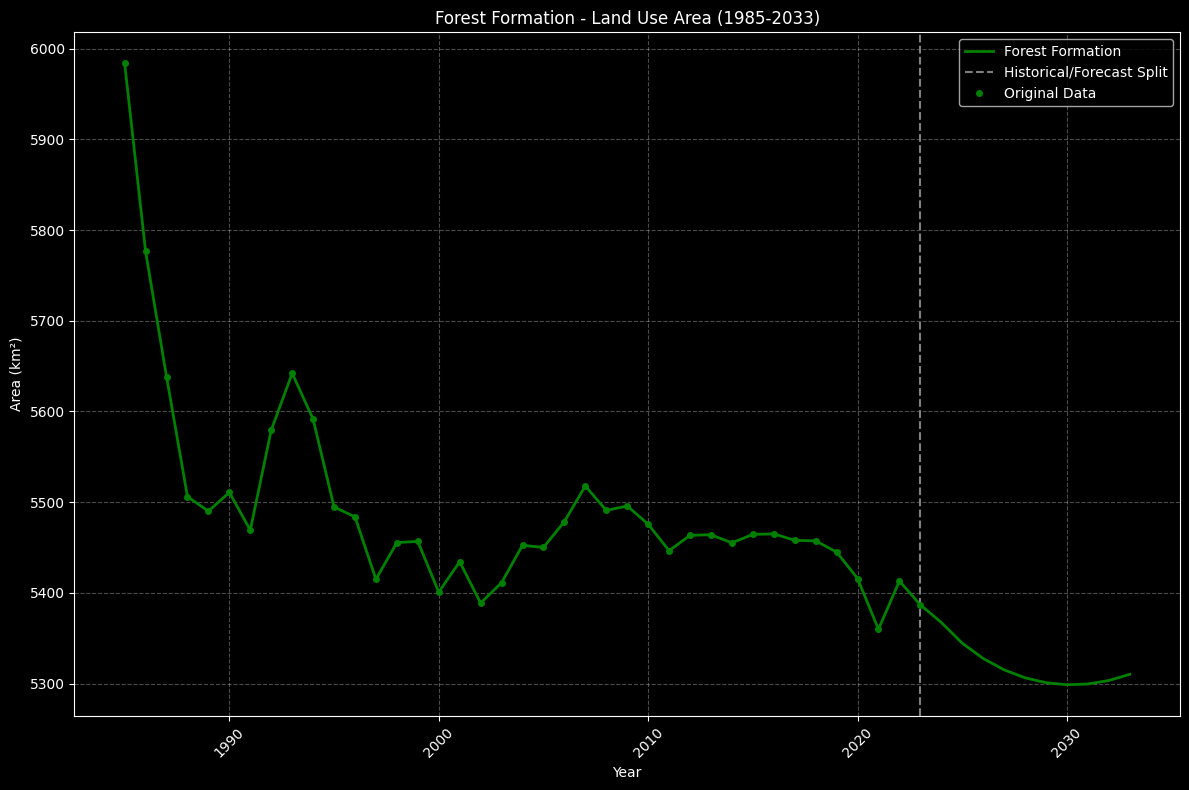

Line graph for Forest Formation saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Forest_Formation.png


<Figure size 640x480 with 0 Axes>

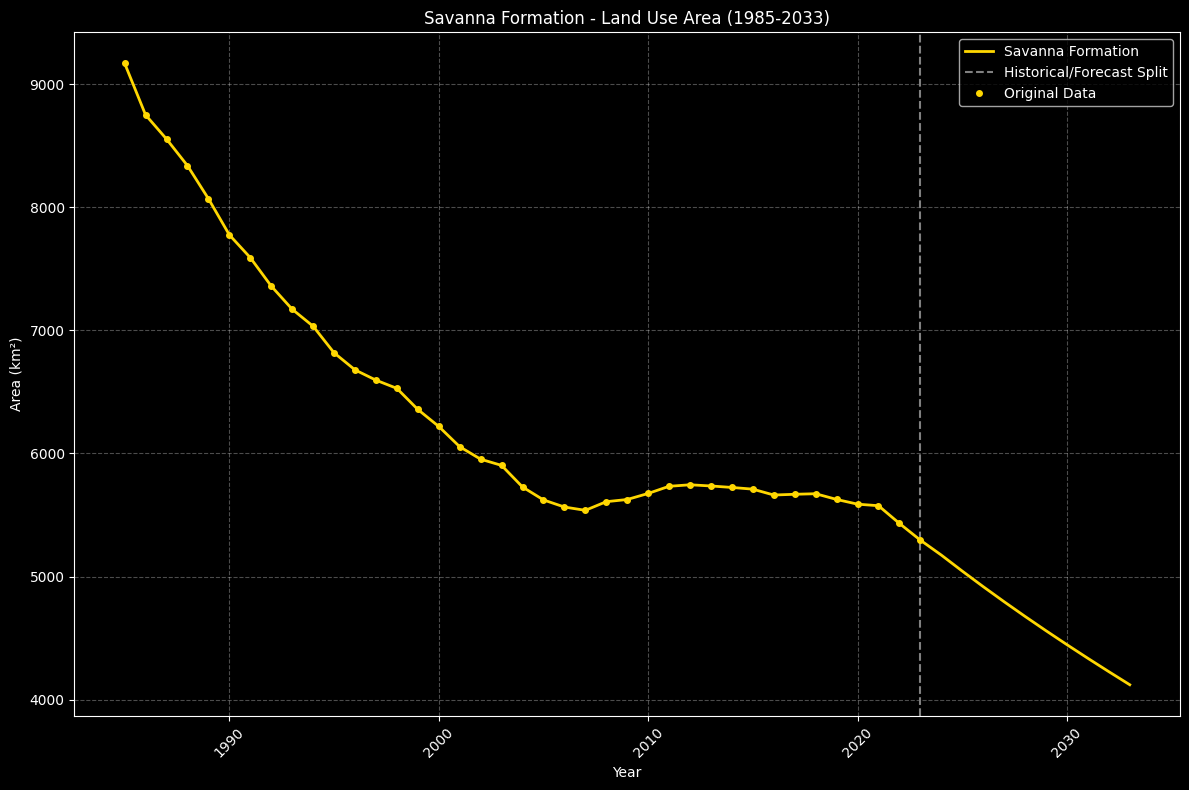

Line graph for Savanna Formation saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Savanna_Formation.png


<Figure size 640x480 with 0 Axes>

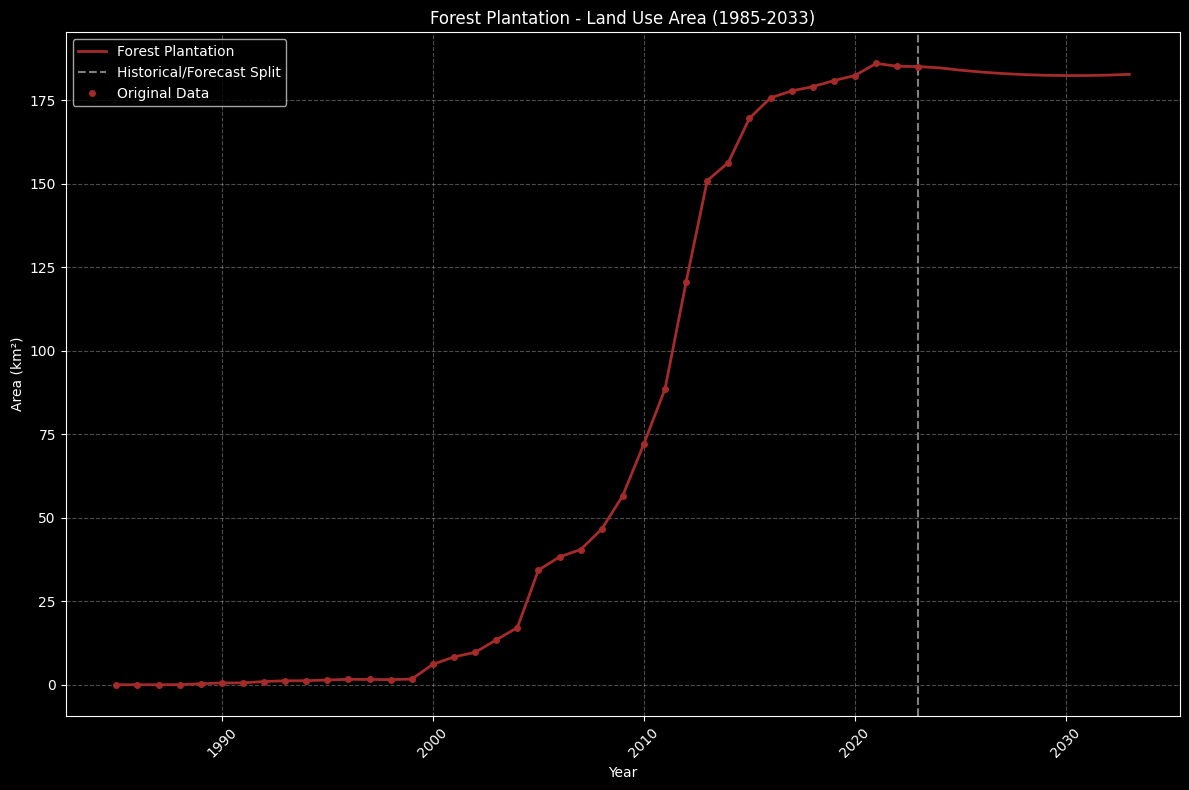

Line graph for Forest Plantation saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Forest_Plantation.png


<Figure size 640x480 with 0 Axes>

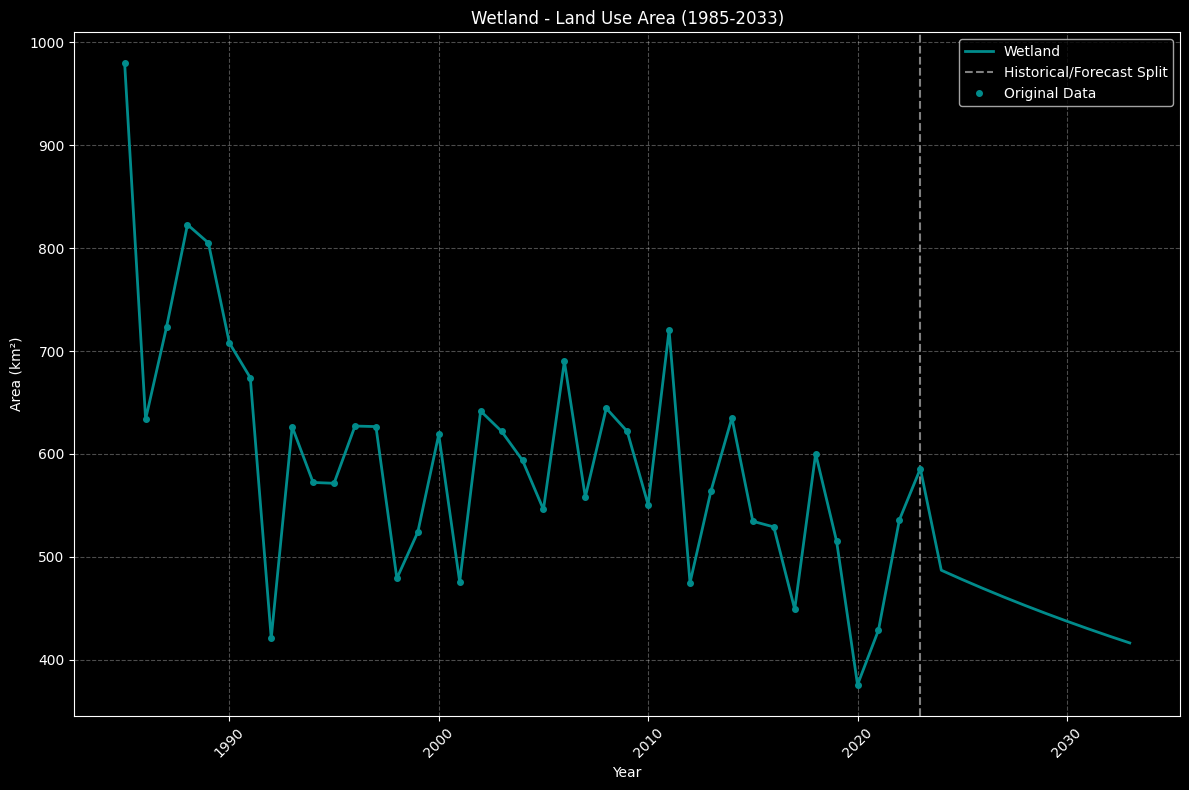

Line graph for Wetland saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Wetland.png


<Figure size 640x480 with 0 Axes>

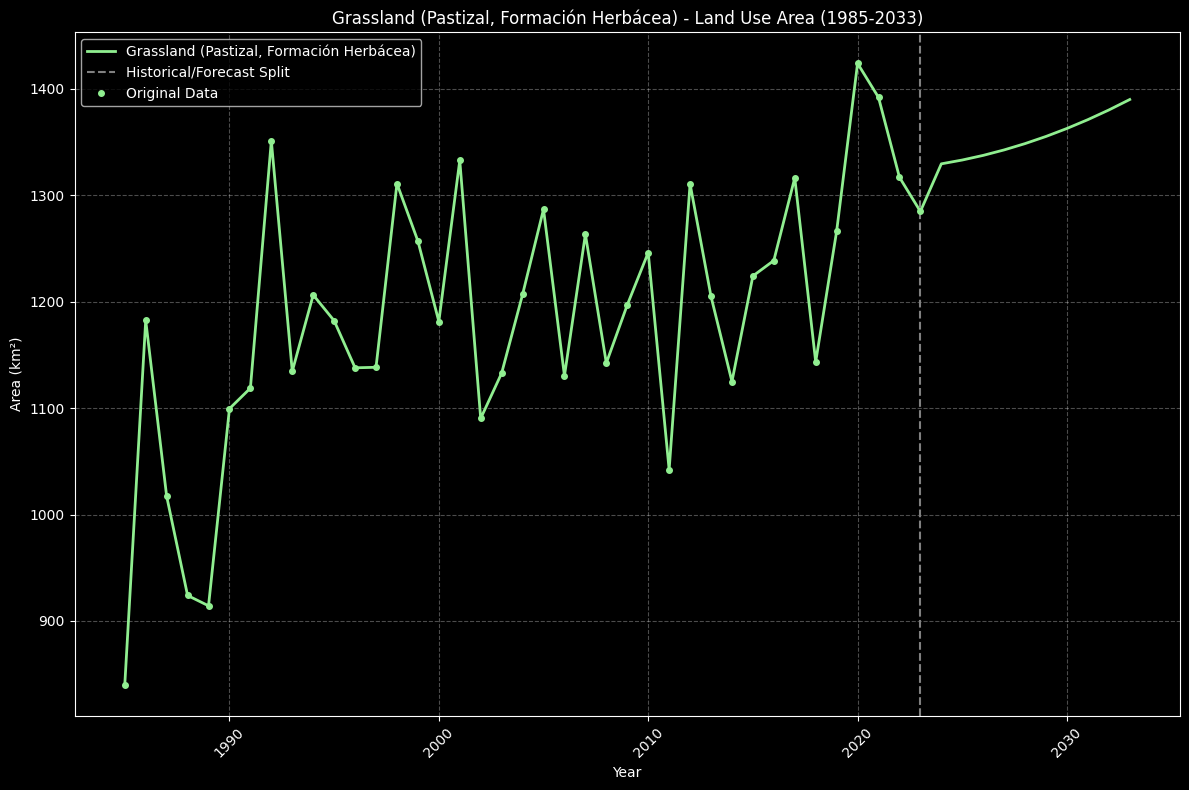

Line graph for Grassland (Pastizal, Formación Herbácea) saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Grassland_(Pastizal,_Formación_Herbácea).png


<Figure size 640x480 with 0 Axes>

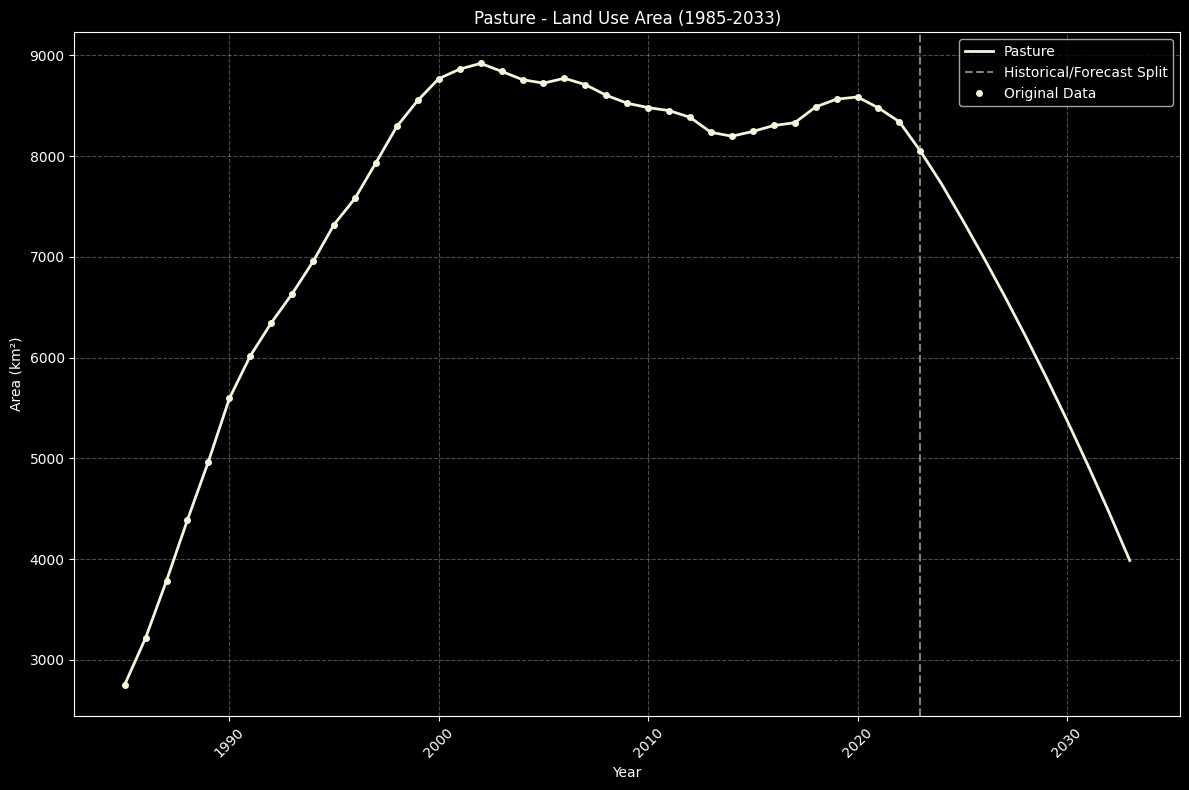

Line graph for Pasture saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Pasture.png


<Figure size 640x480 with 0 Axes>

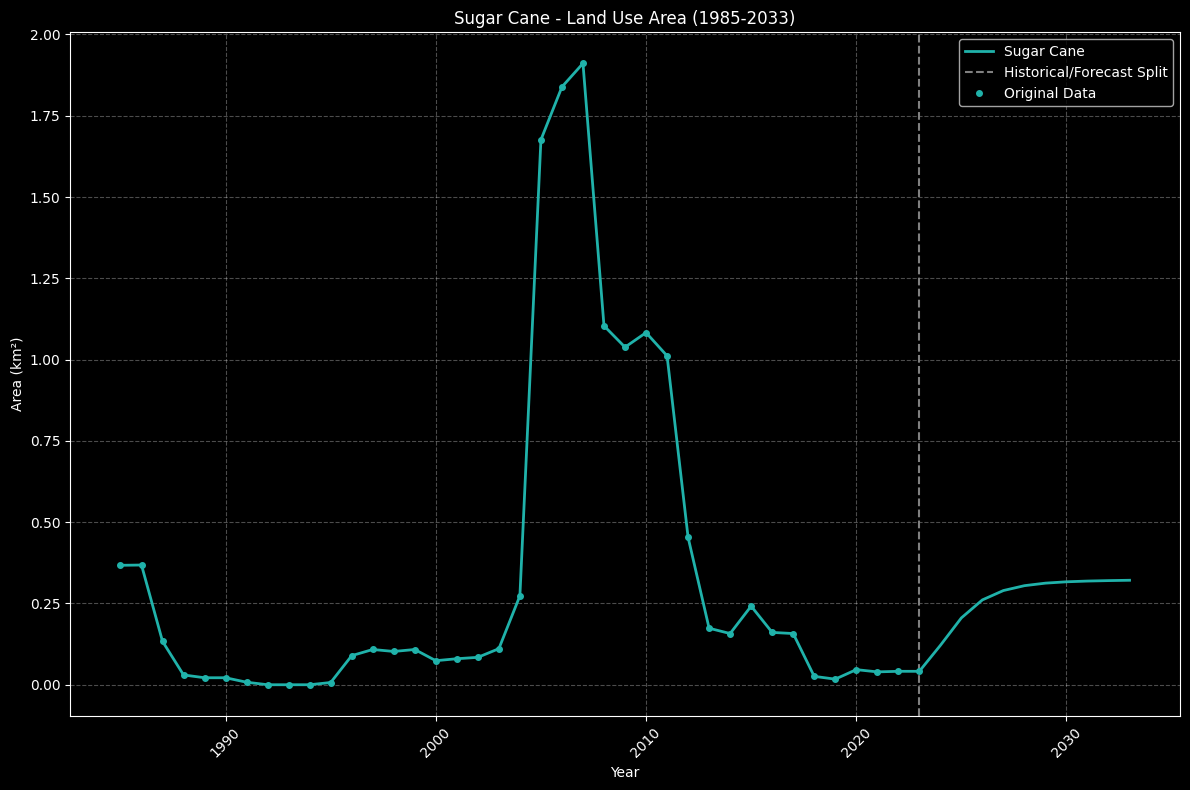

Line graph for Sugar Cane saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Sugar_Cane.png


<Figure size 640x480 with 0 Axes>

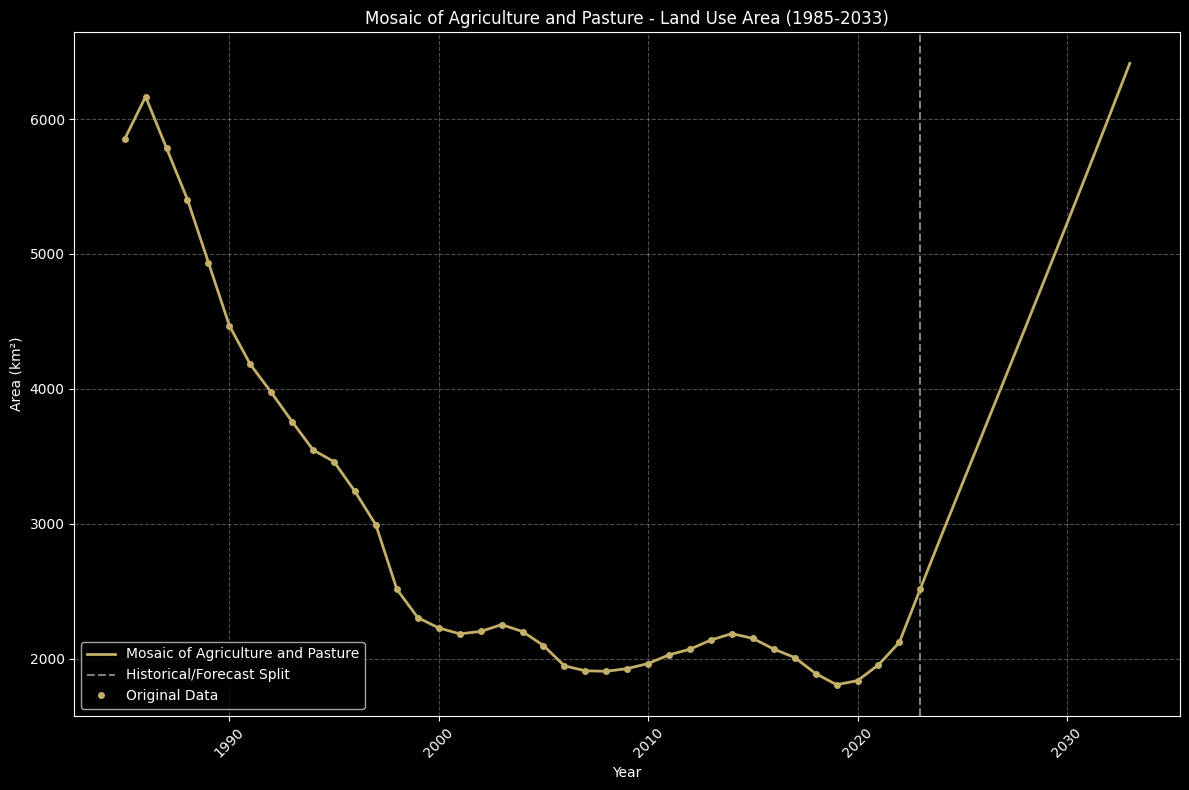

Line graph for Mosaic of Agriculture and Pasture saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Mosaic_of_Agriculture_and_Pasture.png


<Figure size 640x480 with 0 Axes>

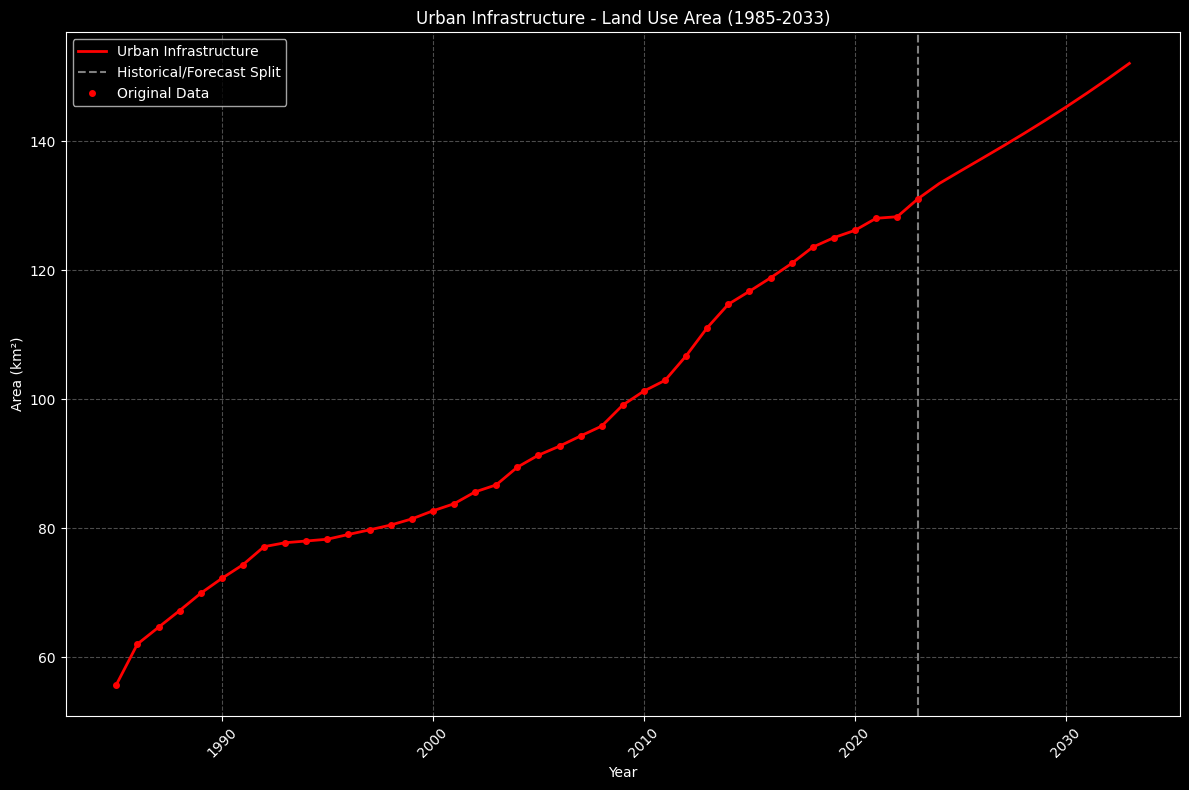

Line graph for Urban Infrastructure saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Urban_Infrastructure.png


<Figure size 640x480 with 0 Axes>

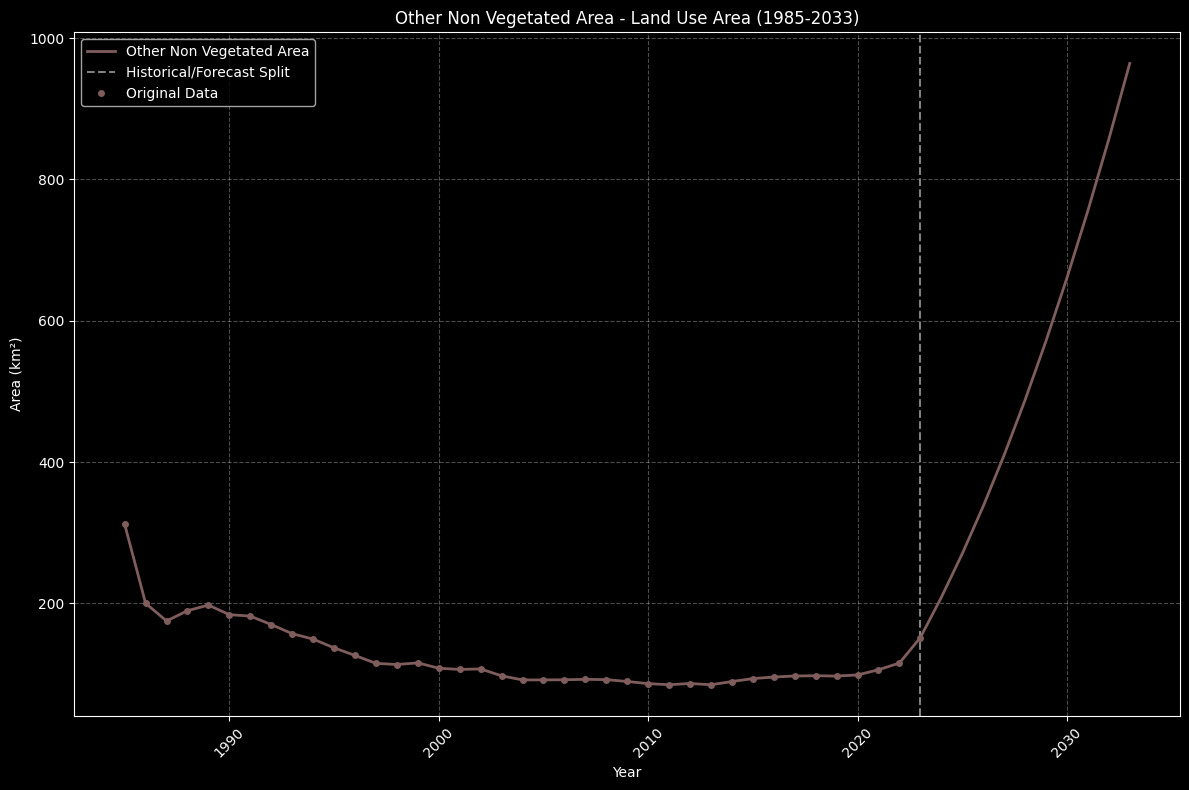

Line graph for Other Non Vegetated Area saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Other_Non_Vegetated_Area.png


<Figure size 640x480 with 0 Axes>

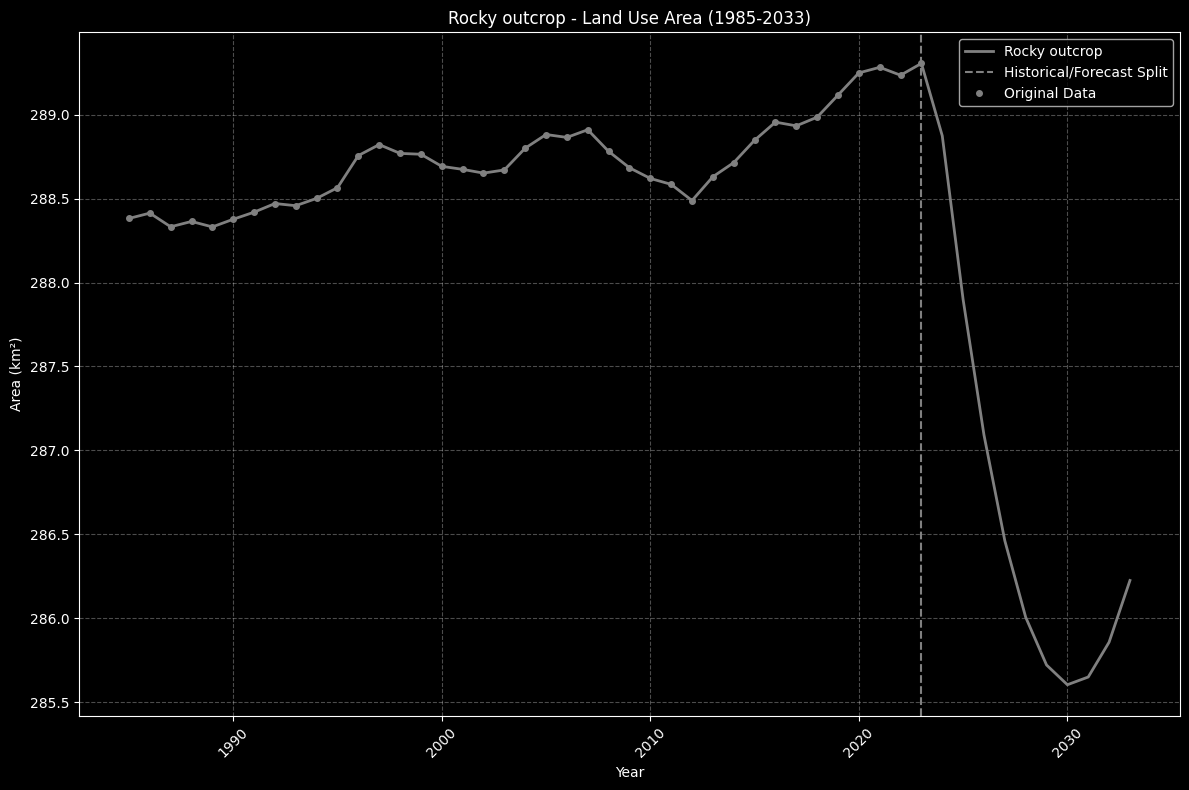

Line graph for Rocky outcrop saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Rocky_outcrop.png


<Figure size 640x480 with 0 Axes>

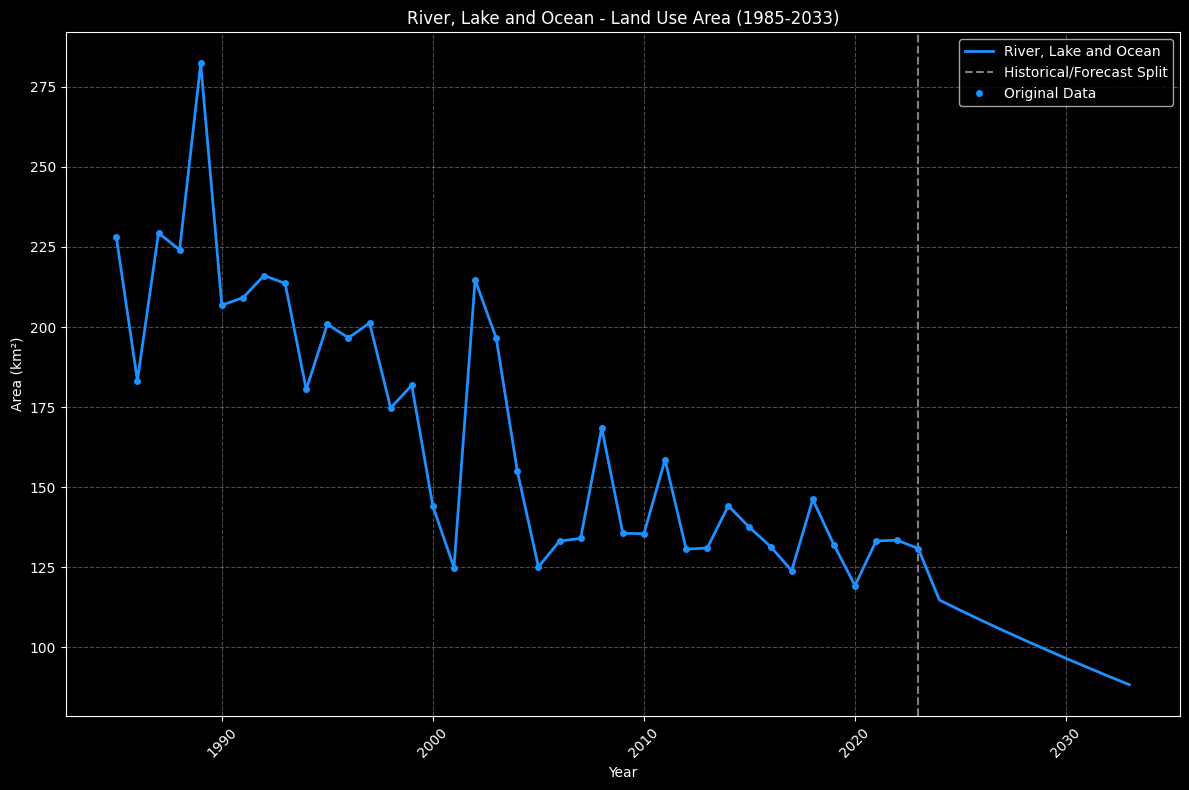

Line graph for River, Lake and Ocean saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_River,_Lake_and_Ocean.png


<Figure size 640x480 with 0 Axes>

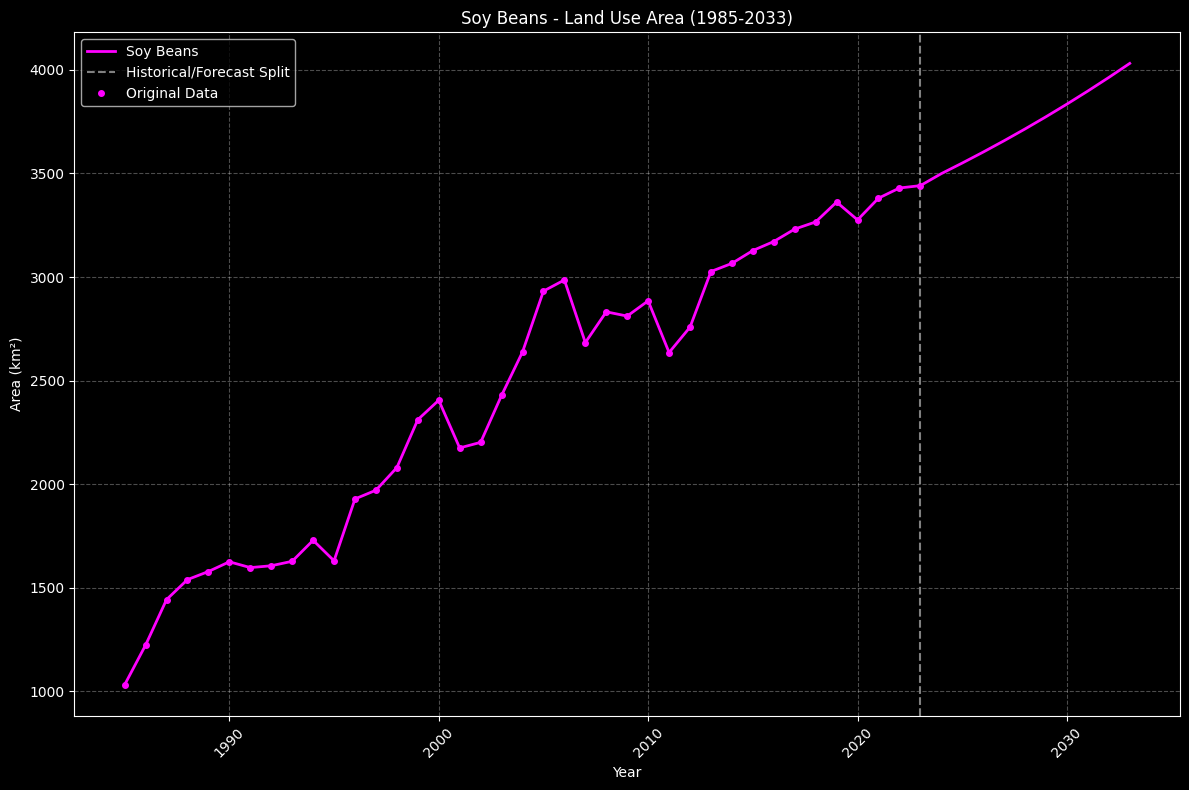

Line graph for Soy Beans saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Soy_Beans.png


<Figure size 640x480 with 0 Axes>

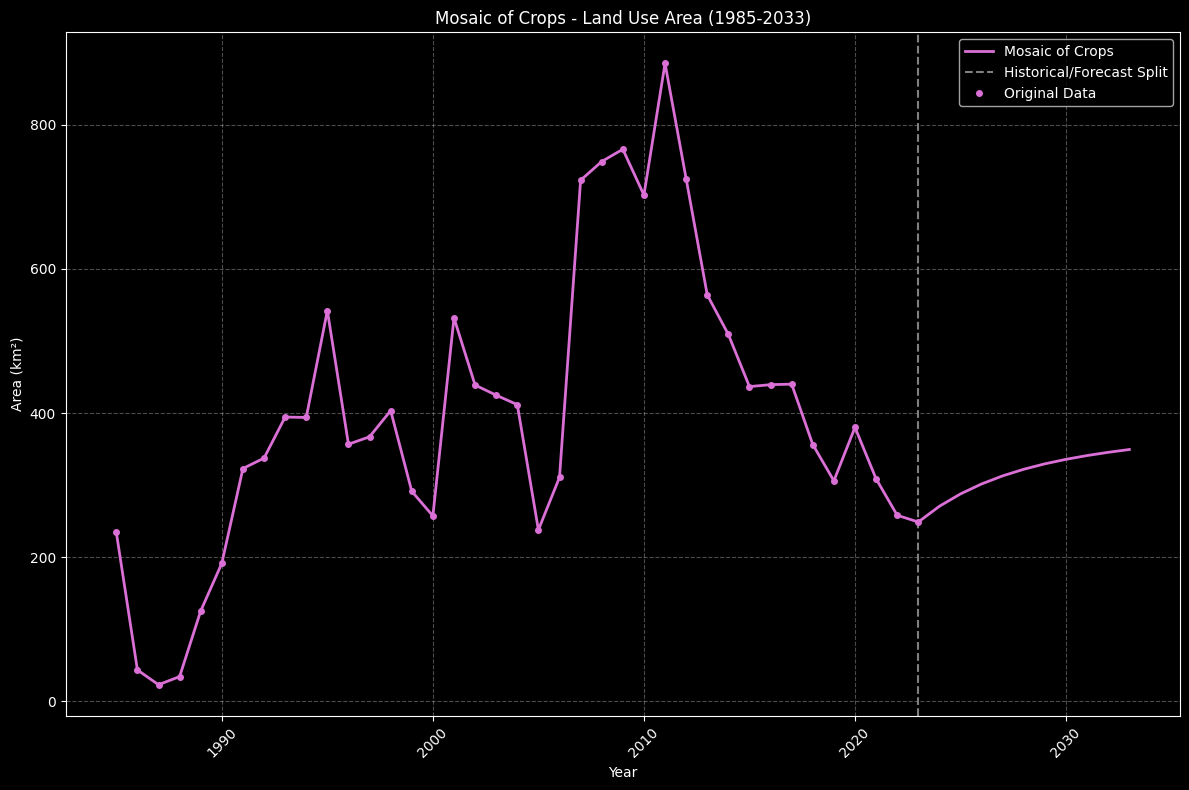

Line graph for Mosaic of Crops saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Mosaic_of_Crops.png


<Figure size 640x480 with 0 Axes>

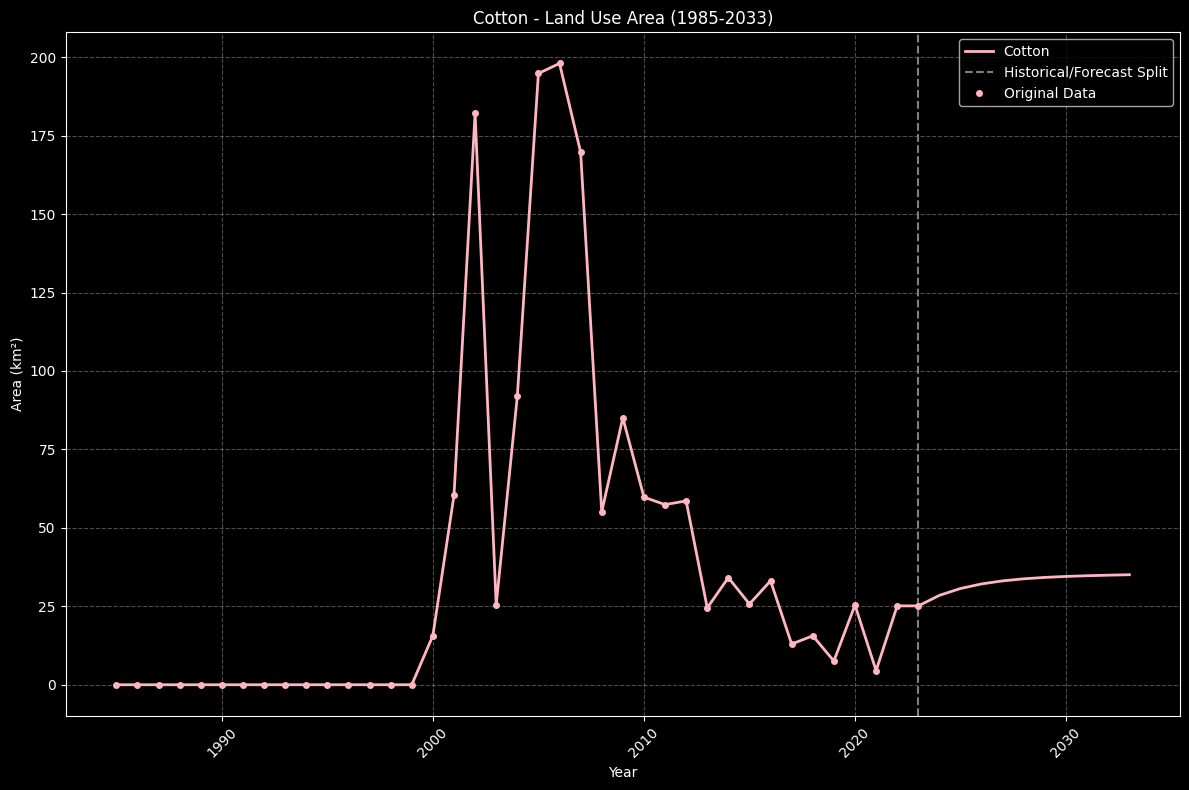

Line graph for Cotton saved to C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs\Line_AllYears_Cotton.png


<Figure size 640x480 with 0 Axes>

In [18]:

# Class colors
class_colors = {
    'Forest Formation': 'green', 'Savanna Formation': 'gold', 'Forest Plantation': 'brown',
    'Wetland': 'darkcyan', 'Grassland (Pastizal, Formación Herbácea)': 'lightgreen',
    'Pasture': 'beige', 'Sugar Cane': 'lightseagreen', 'Mosaic of Agriculture and Pasture': '#c3af68',
    'Urban Infrastructure': 'red', 'Other Non Vegetated Area': '#7f5d5d',
    'Rocky outcrop': 'gray', 'River, Lake and Ocean': 'dodgerblue', 'Soy Beans': 'magenta',
    'Mosaic of Crops': 'orchid', 'Cotton': 'lightpink'
}

# Style
plt.style.use('dark_background')
plt.rcParams.update({'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'})

# Output folder
output_folder = r'C:\Users\RaulA\OneDrive\Documents\IAAC\Thesis - Digital Urban Landscapes\Graphics\Presentatio 02\Graphs'
os.makedirs(output_folder, exist_ok=True)

# Line graphs: All years (original + forecast) per class
for class_name in pivot_df.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Handle NaNs in forecast data
    full_series = forecast_df[class_name].interpolate().fillna(method='ffill').fillna(0)
    
    # Plot full series (1985-2033)
    ax.plot(forecast_df.index.year, full_series, label=class_name, color=class_colors[class_name], linewidth=2)
    
    # Mark the split between historical and forecast
    ax.axvline(x=2023, color='gray', linestyle='--', label='Historical/Forecast Split')
    
    # Add markers for original data points (1985-2023)
    ax.plot(pivot_df.index.year, pivot_df[class_name], 'o', color=class_colors[class_name], markersize=4, label='Original Data')
    
    # Customize
    ax.set_title(f'{class_name} - Land Use Area (1985-2033)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Area (km²)')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    output_path = os.path.join(output_folder, f'Line_AllYears_{class_name.replace(" ", "_")}.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='black')
    plt.close(fig)
    print(f'Line graph for {class_name} saved to {output_path}')

C:\Users\RaulA\AppData\Local\Temp\ipykernel_10296\191929349.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_series = forecast_df[class_name].interpolate().fillna(method='ffill').fillna(0)


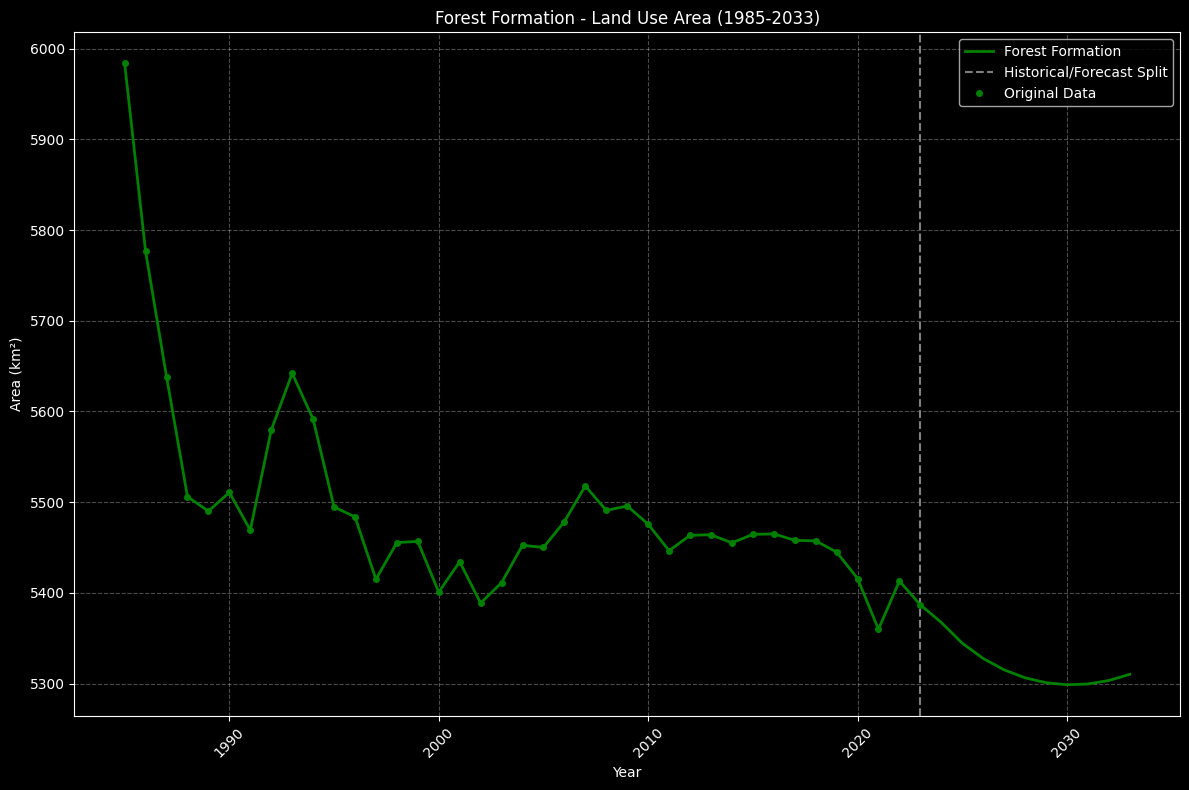

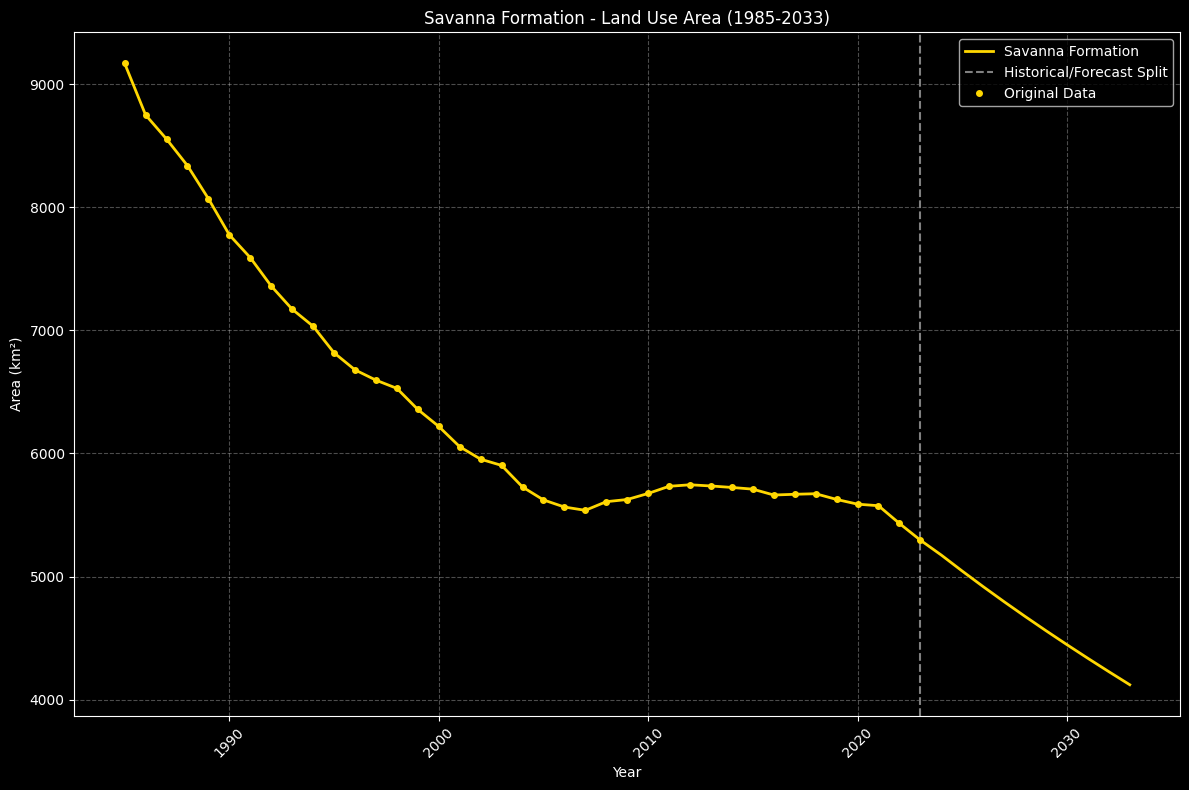

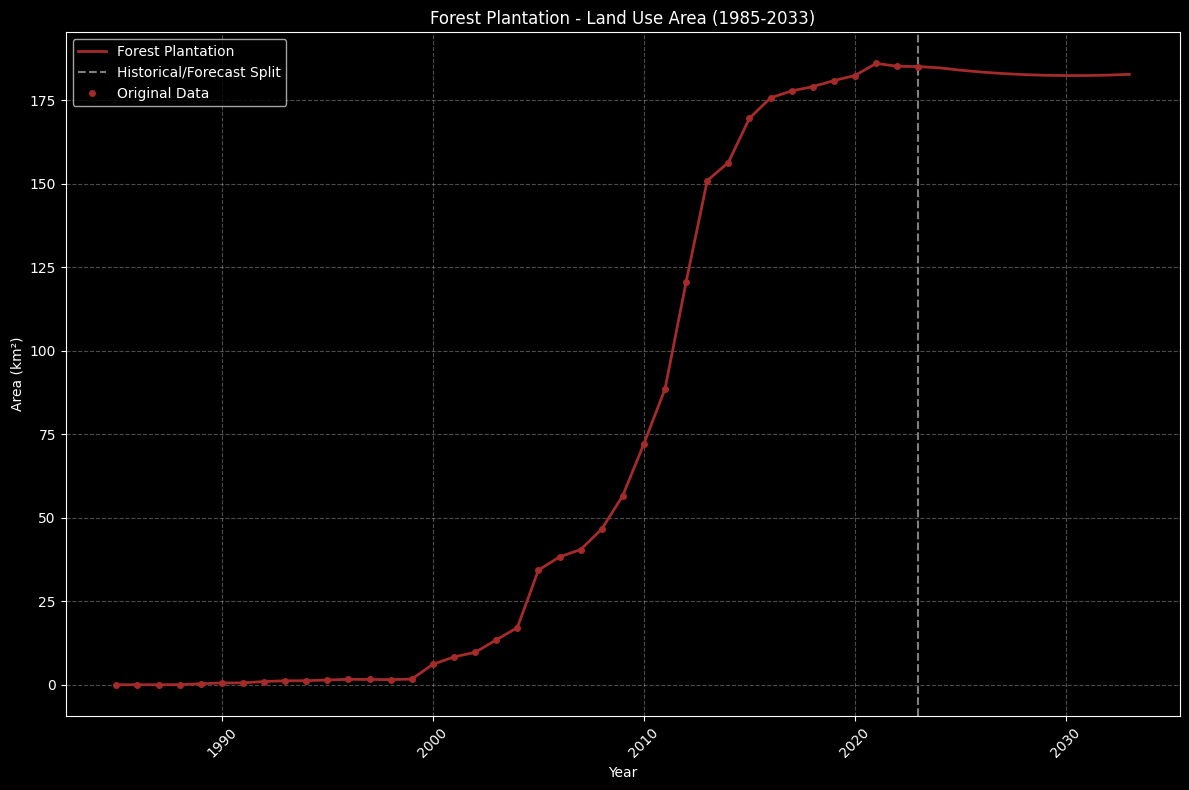

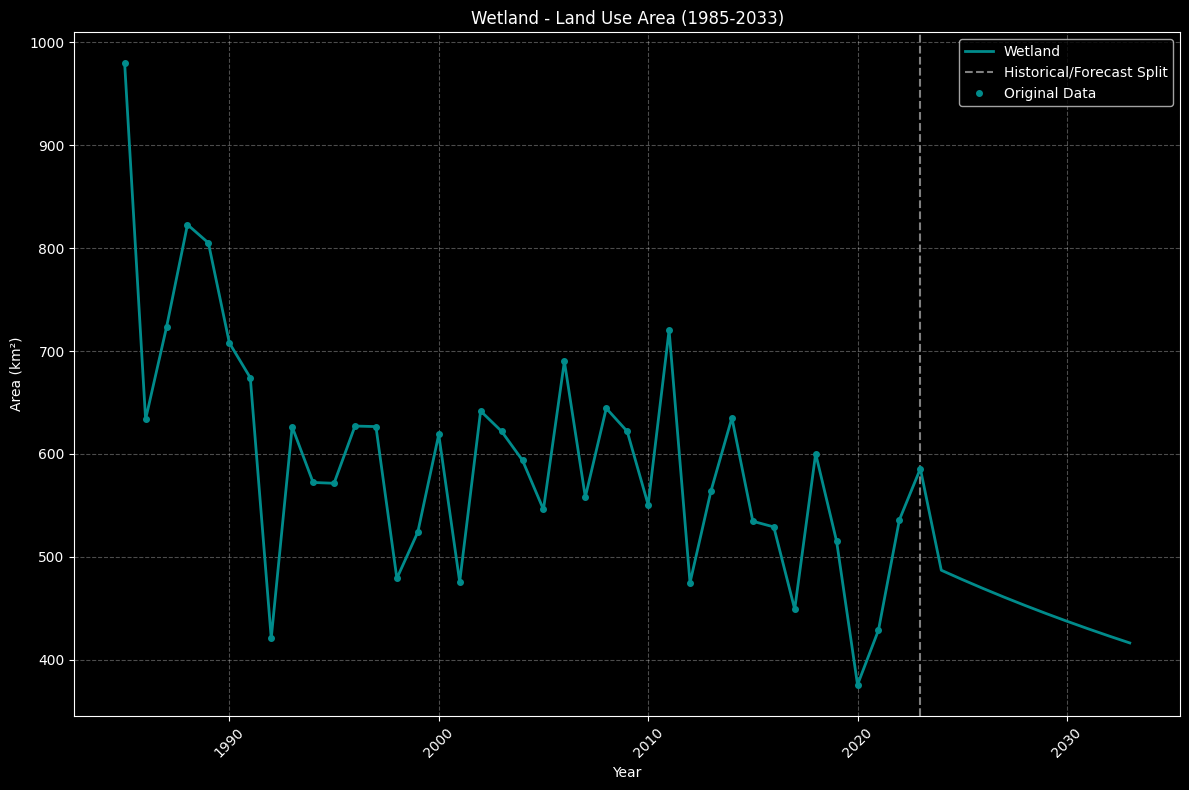

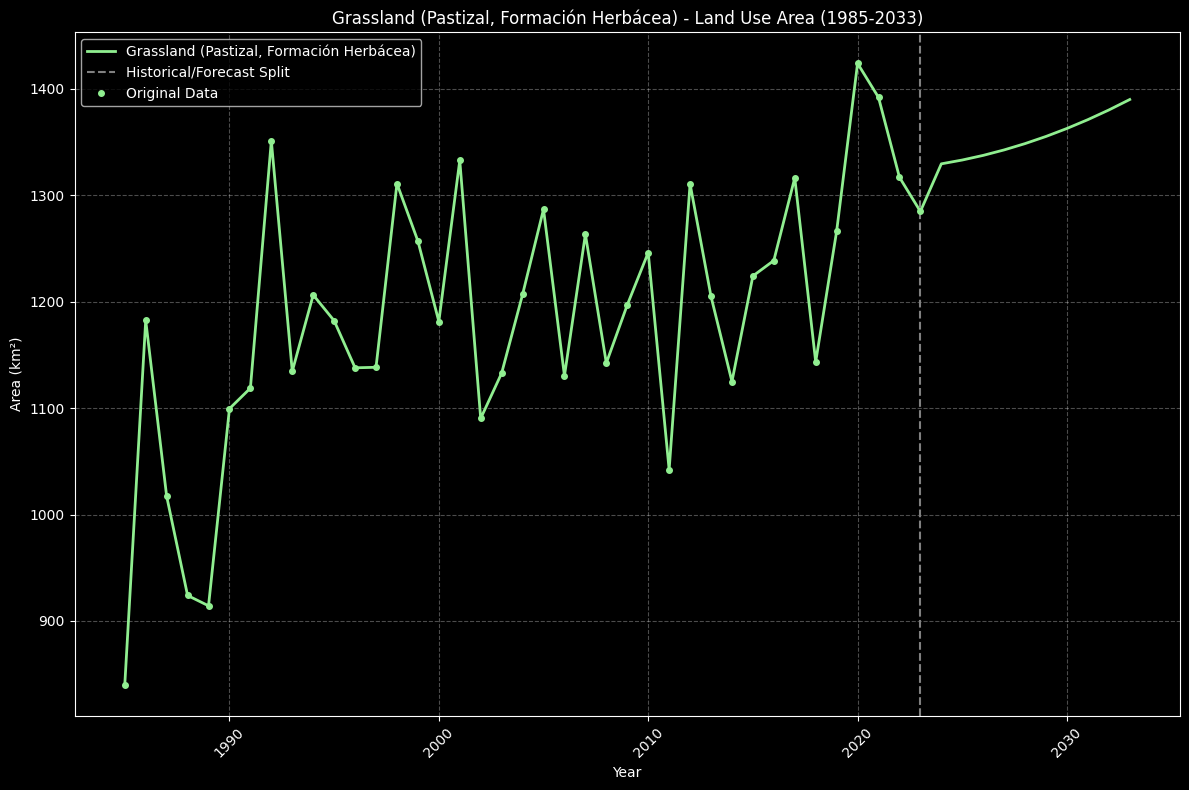

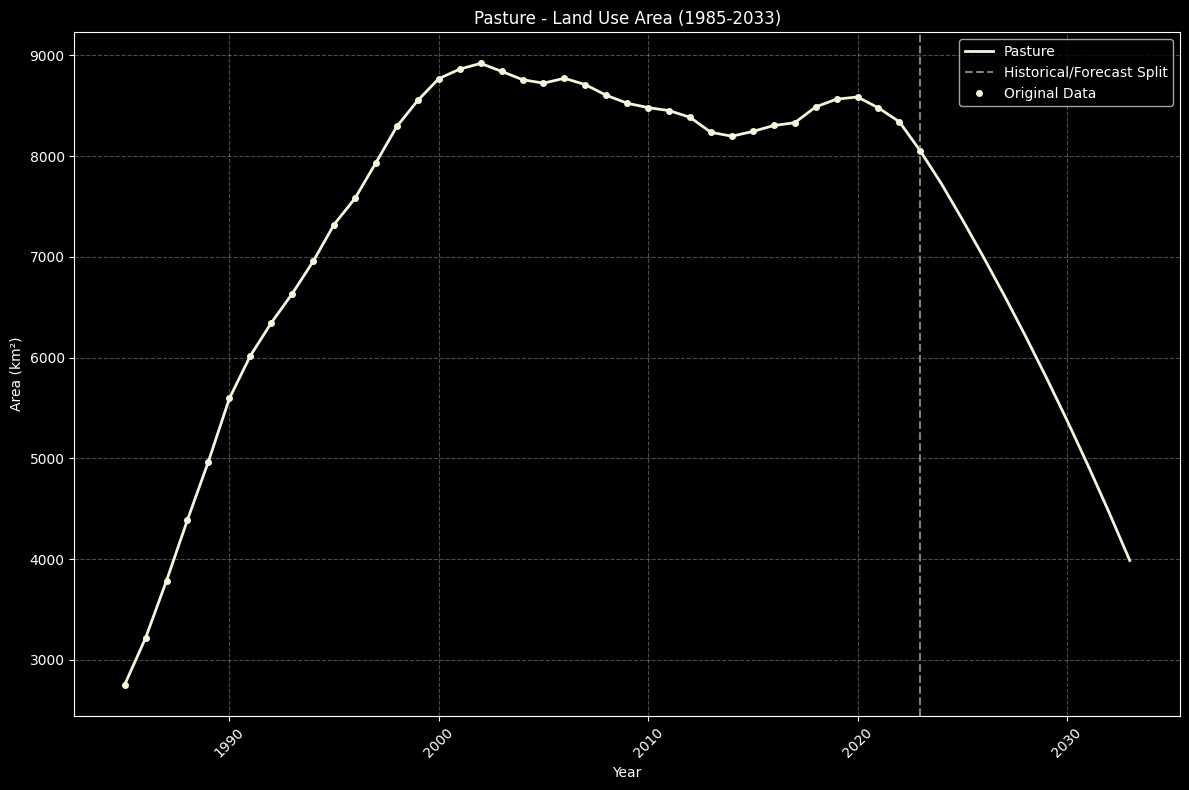

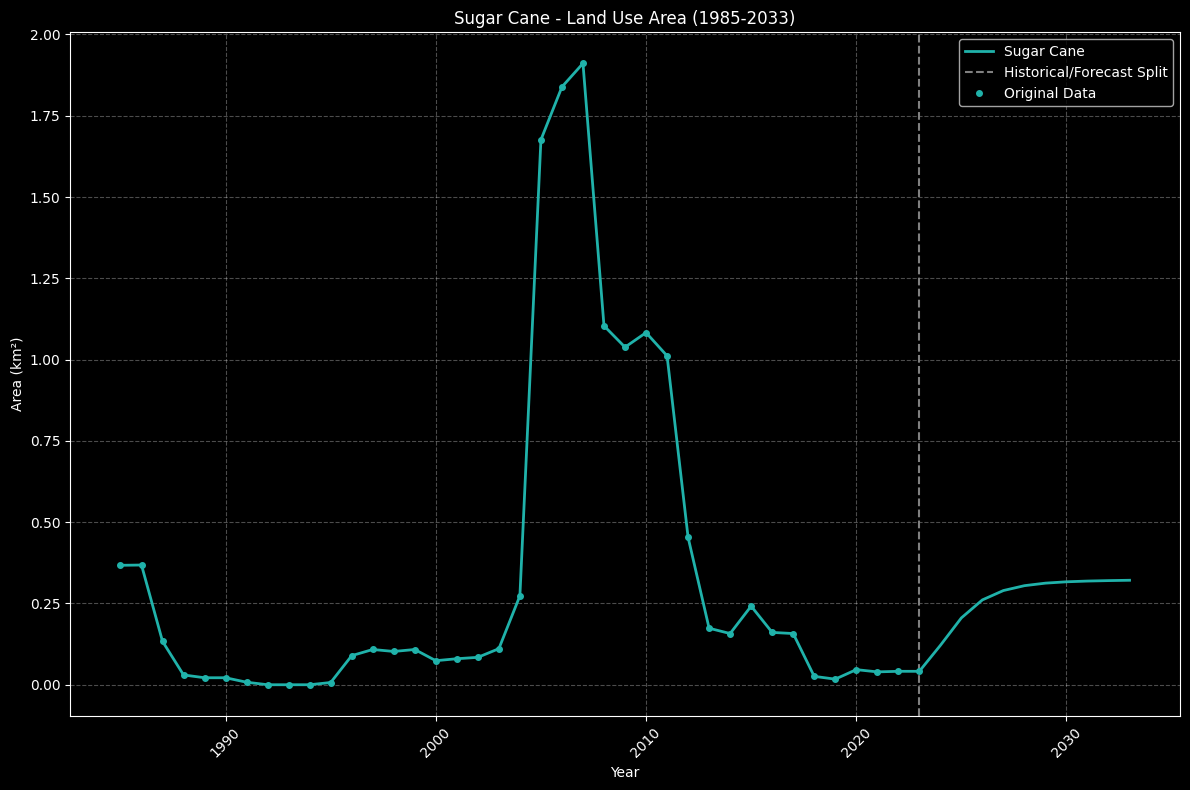

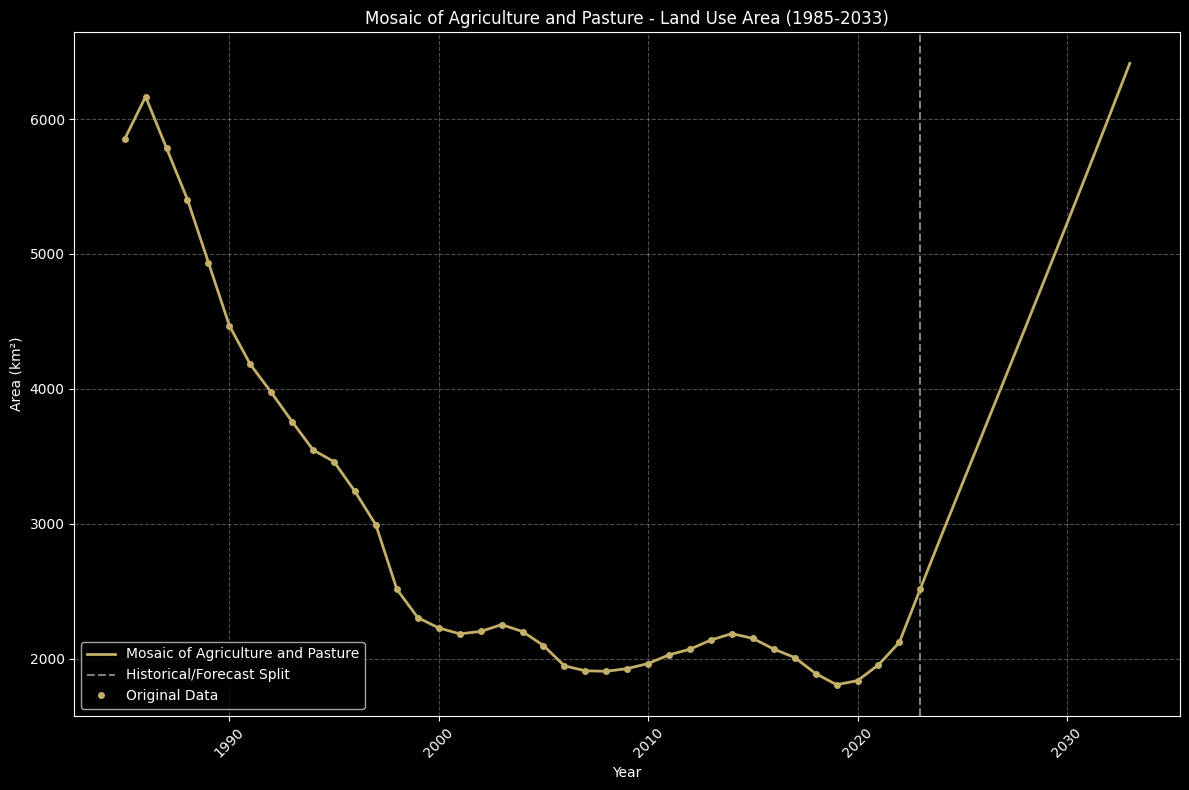

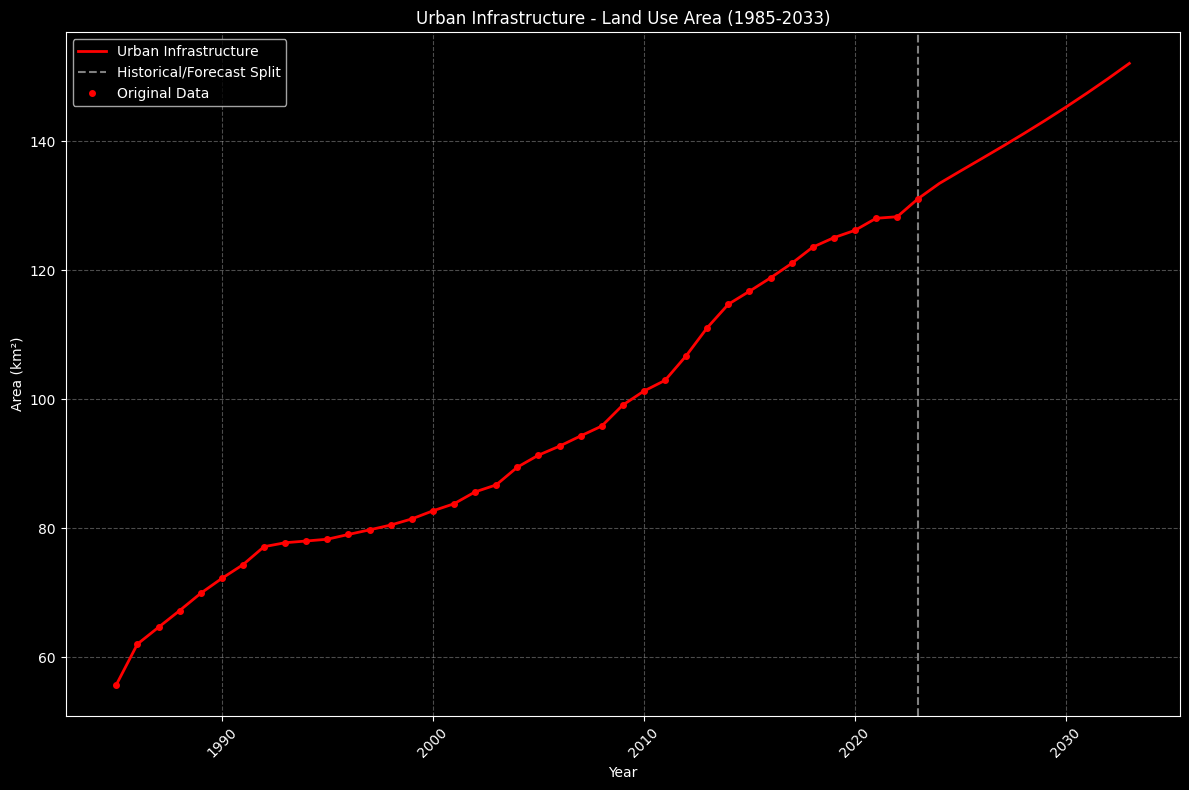

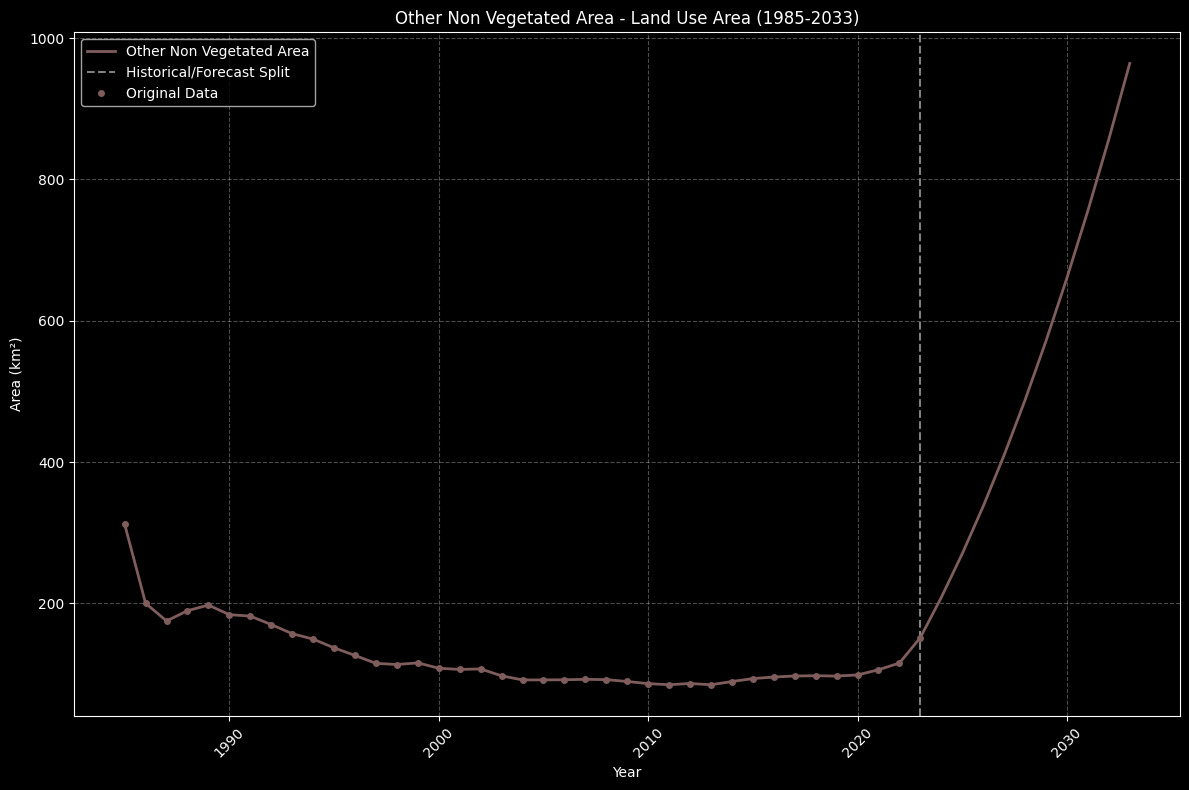

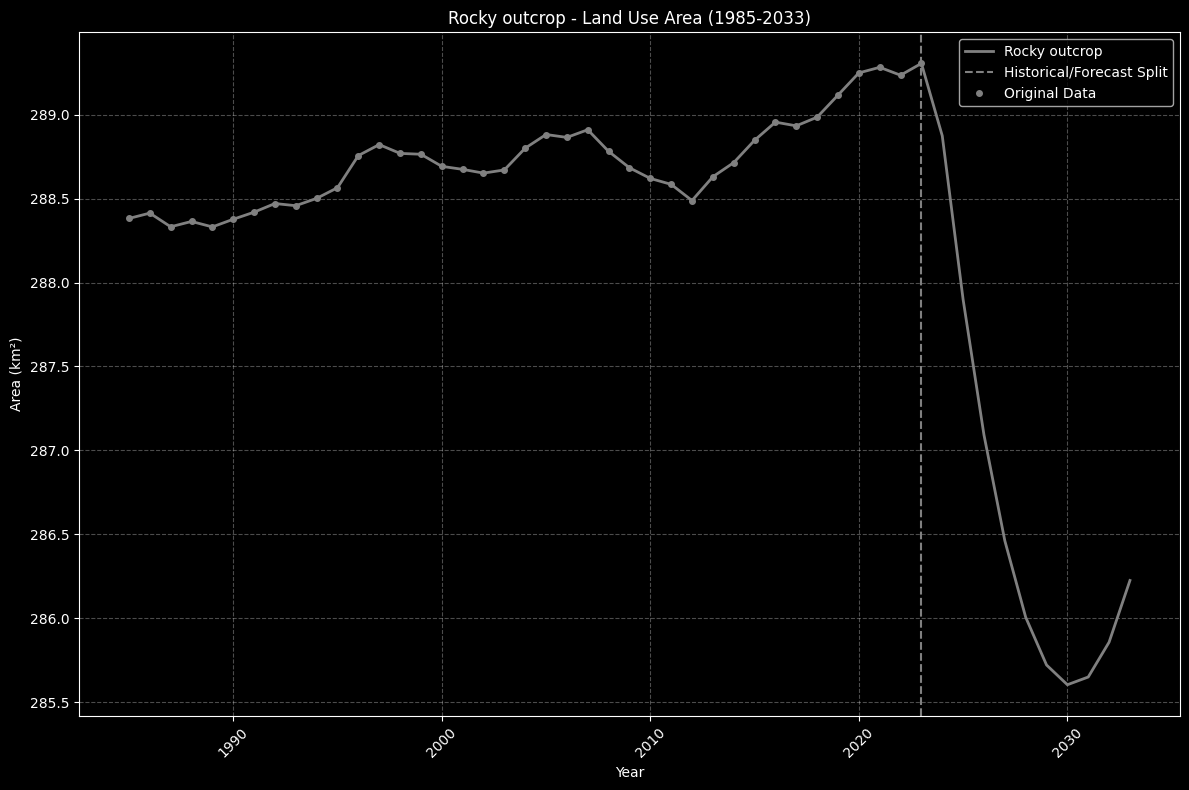

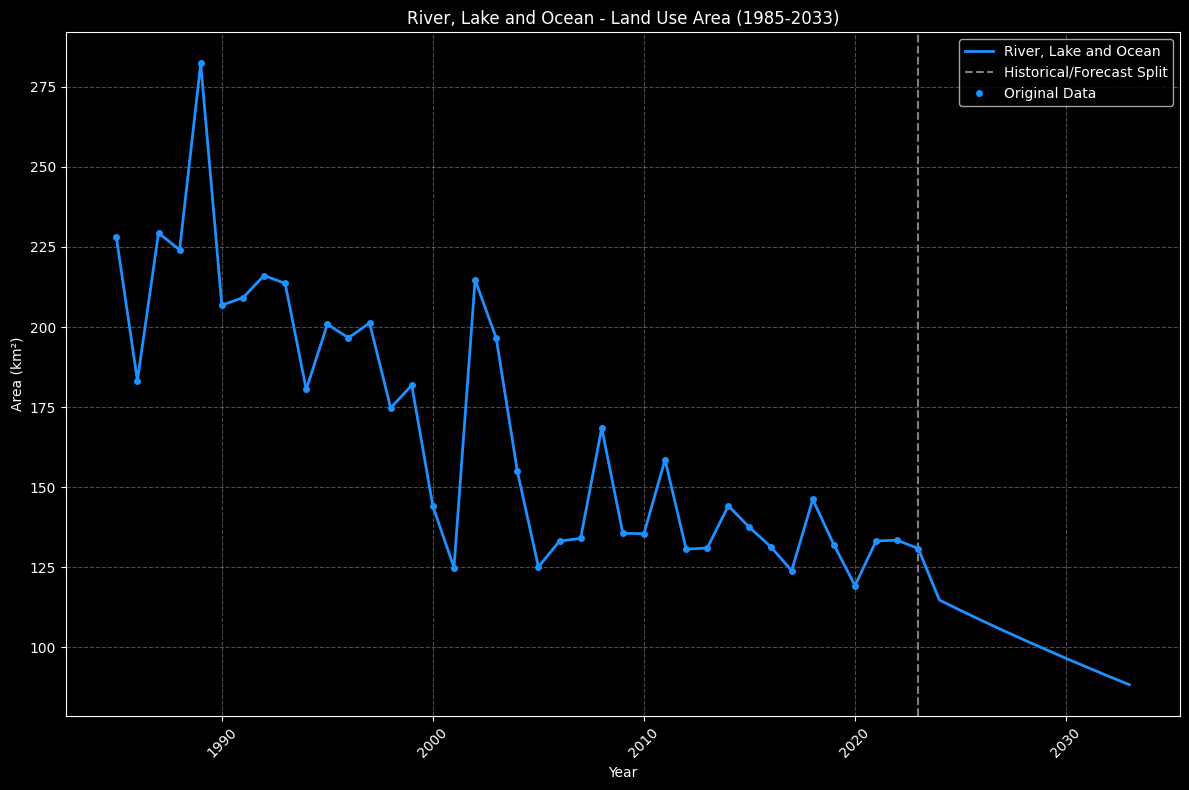

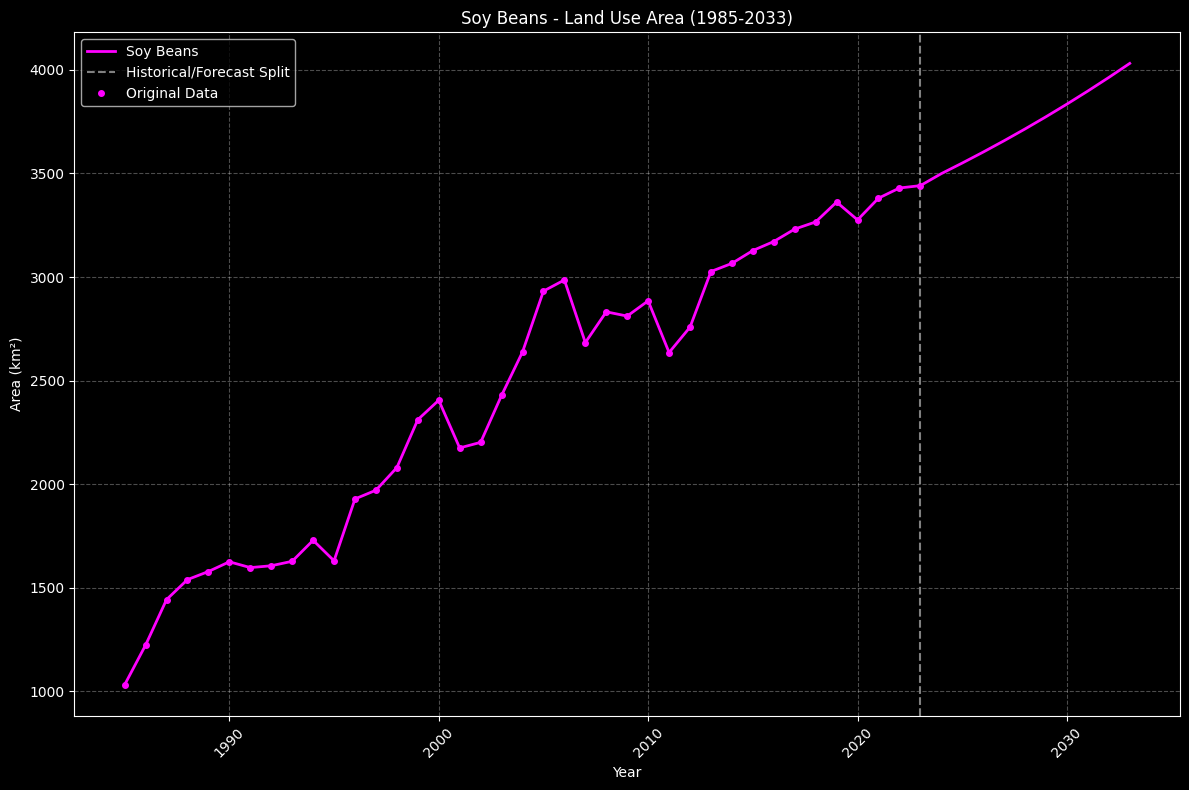

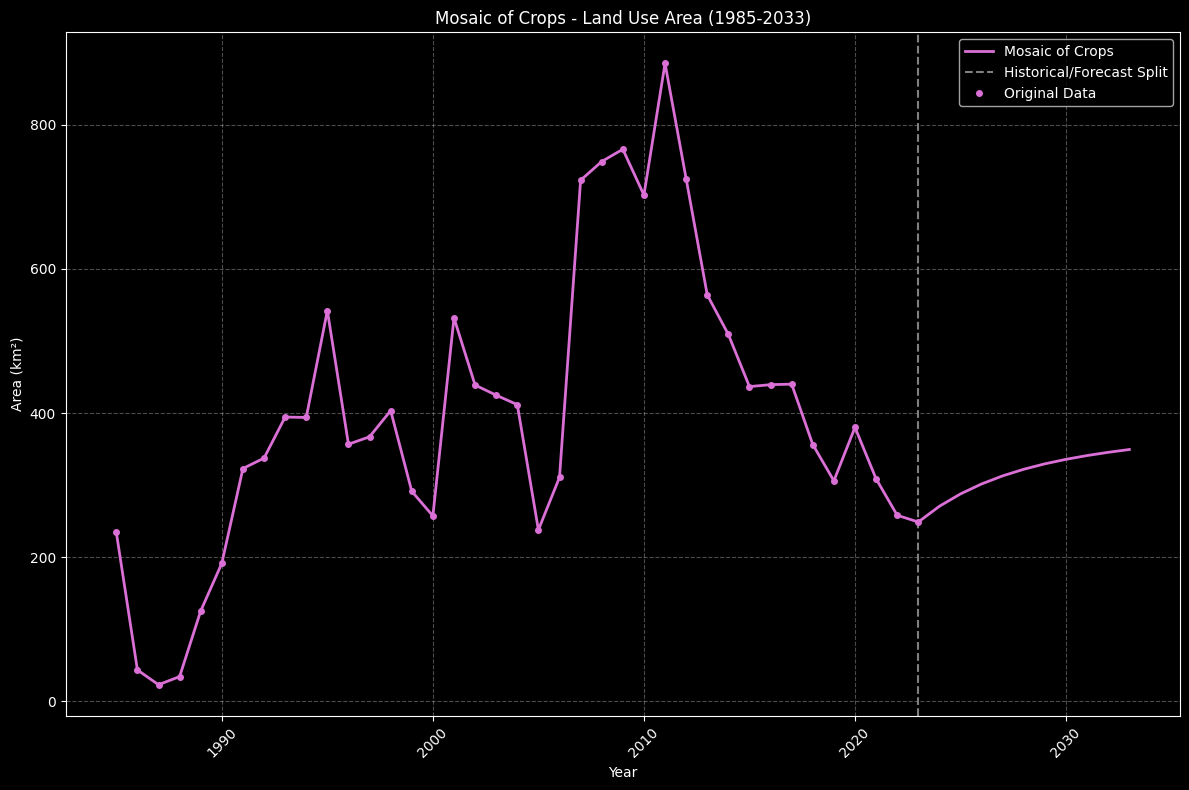

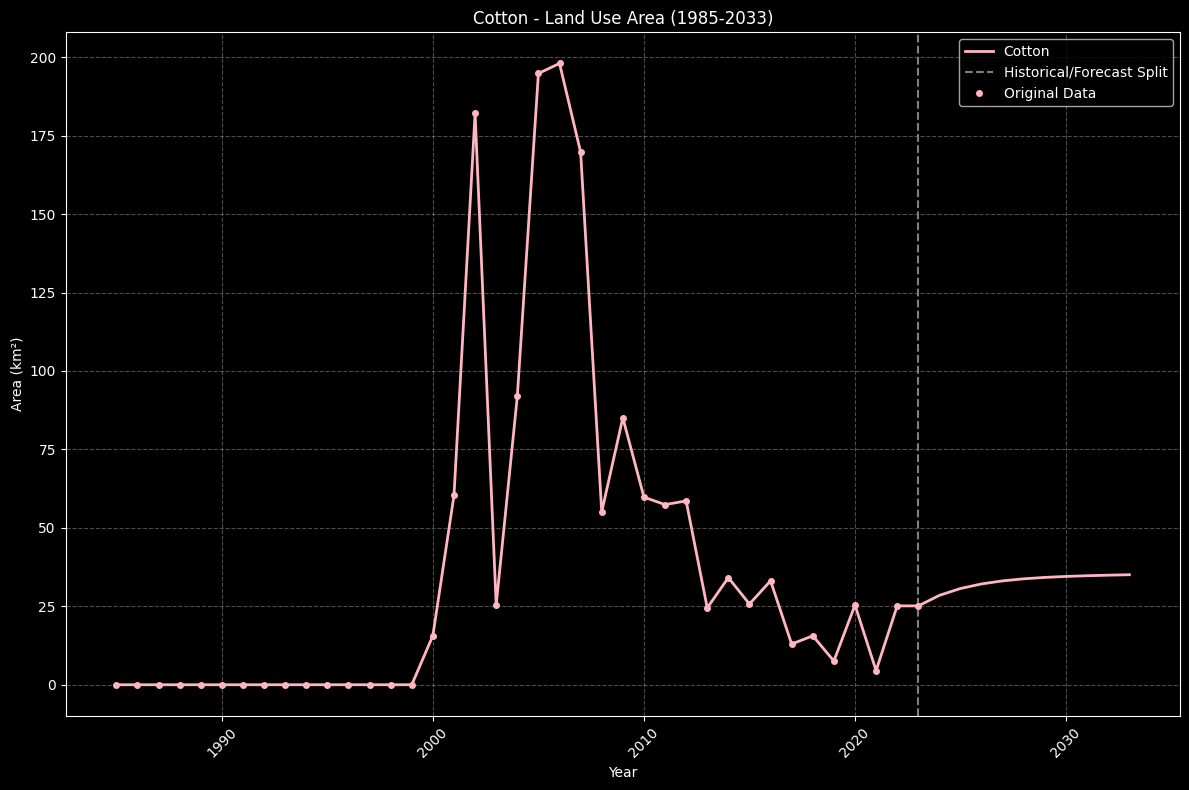

In [19]:
# Ensure plots show inline in VSCode
%matplotlib inline

# Style
plt.style.use('dark_background')
plt.rcParams.update({'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'})

# Line graphs: All years (original + forecast) per class
for class_name in pivot_df.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Handle NaNs in forecast data
    full_series = forecast_df[class_name].interpolate().fillna(method='ffill').fillna(0)
    
    # Plot full series (1985-2033)
    ax.plot(forecast_df.index.year, full_series, label=class_name, color=class_colors[class_name], linewidth=2)
    
    # Mark the split between historical and forecast
    ax.axvline(x=2023, color='gray', linestyle='--', label='Historical/Forecast Split')
    
    # Add markers for original data points (1985-2023)
    ax.plot(pivot_df.index.year, pivot_df[class_name], 'o', color=class_colors[class_name], markersize=4, label='Original Data')
    
    # Customize
    ax.set_title(f'{class_name} - Land Use Area (1985-2033)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Area (km²)')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot inline
    plt.show()